# Compute Trigger Efficiencies

### In this script, we use the output of a tag-N-probe script to select Z->mu mu events that generate a shower in the CMS Muon Detectors via muon brehmstahlung. We want to compute the efficiency of the HLT triggers that fire upon the production of a shower in the muon endcaps (CSCs). The "tag" muon with tighter ID enables us to select a high purity Z->mu mu sample, while the probe muon, with looser ID constraints, is matched to a cluster in the CSC (we do not require a tight ID on the probe muon to avoid biasing cluster selection). The size of a cluster is the main discriminator, but the HLT threshold varies with eta and NStation10. We compute the trigger efficiency as a function of these three variables.

In [7]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"../")
import mplhep as hep
import pickle
import glob
import ROOT
import coffea
import awkward as ak
from coffea import hist, processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector


Warning in <TInterpreter::ReadRootmapFile>: class  HepMC::FourVector found in libSimDataFormatsGeneratorProducts.so  is already in libHepMC3rootIO.so 


Welcome to JupyROOT 6.28/00


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  r

### Load Output Trees from TnP

In [40]:
eras = ["all", "2022", "2023"]

In [9]:
# #paths to data
# path_all  = "/eos/uscms/store/user/amalbert/MDSTriggerEff/trigEff_output_combined_updated/triggEff_2022_2023_goodlumi.root"
# path_2022 = "/eos/uscms/store/user/amalbert/MDSTriggerEff/trigEff_output_2022_updated/fixedMerge_trigEff_2022_052024_goodlumi.root"
# path_2023 = "/eos/uscms/store/user/amalbert/MDSTriggerEff/trigEff_output_2023_updated/trigEff_2023_052024_goodlumi.root"#
# #path_all  = "/eos/uscms/store/user/amalbert/MDSTriggerEff/TrigEff_Output_newMerge_withJets/TrigEff_Output_2022_2023_081524.root"
# #path_2022 = "/eos/uscms/store/user/amalbert/MDSTriggerEff/TrigEff_Output_newMerge_withJets/TrigEff_Output_2022_081524.root"
# #path_2023 = "/eos/uscms/store/user/amalbert/MDSTriggerEff/TrigEff_Output_newMerge_withJets/TrigEff_Output_2023_081524.root"
# path_2023B =  "/eos/uscms/store/user/amalbert/MDSTriggerEff/trigEff_output_2023_updated/trigEff_2023B_052024_goodlumi.root"
# path_2023C =  "/eos/uscms/store/user/amalbert/MDSTriggerEff/trigEff_output_2023_updated/trigEff_2023C_052024_goodlumi.root"
# path_2023D = "/eos/uscms/store/user/amalbert/MDSTriggerEff/trigEff_output_2023_updated/trigEff_2023D_052024_goodlumi.root"

In [15]:
ak.behavior.update(candidate.behavior)

def getLZDF(f,nEvents=-1,version="new"): #lazy dataframe with events that have cluster matched to probe muon
    events_raw = uproot.open(f)['MuonSystem']
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    events = events[start:stop]
    return events

In [21]:
paths = {
"path_Run2022E": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/Run2022E_TrigEff.root",
"path_Run2022F": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/Run2022F_TrigEff.root",
"path_Run2022G": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/Run2022G_TrigEff.root",
"path_Run2023B": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/Run2023B_Muon0_Muon1_TrigEff.root",
"path_Run2023C_Muon0_v1": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/TrigEffOutput_Run2023C_Muon0_v1.root",
"path_Run2023C_Muon0_v2": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/TrigEffOutput_Run2023C_Muon0_v2.root",
"path_Run2023C_Muon0_v3": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/TrigEffOutput_Run2023C_Muon0_v3.root",
"path_Run2023C_Muon0_v4": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/TrigEffOutput_Run2023C_Muon0_v4.root",
"path_Run2023C_Muon1_v1": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/TrigEffOutput_Run2023C_Muon1_v1.root",
"path_Run2023C_Muon1_v2": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/TrigEffOutput_Run2023C_Muon1_v2.root",
"path_Run2023C_Muon1_v3": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/TrigEffOutput_Run2023C_Muon1_v3.root",
"path_Run2023C_Muon1_v4": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/TrigEffOutput_Run2023C_Muon1_v4.root",
"path_Run2023D_Muon0_v1": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/TrigEffOutput_Run2023D_Muon0_v1.root",
"path_Run2023D_Muon0_v2": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/TrigEffOutput_Run2023D_Muon0_v2.root",
"path_Run2023D_Muon1_v1": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/TrigEffOutput_Run2023D_Muon1_v1.root",
"path_Run2023D_Muon1_v2": "/eos/uscms/store/group/lpclonglived/amalbert/HMT_L1_Eff_Output/TrigEffOutput_Run2023D_Muon1_v2.root"
}

In [22]:
# events_all = getLZDF(path_all)
# events_2022 = getLZDF(path_2022)
# events_2023 = getLZDF(path_2023)
# events_2023B = getLZDF(path_2023B)
# events_2023C = getLZDF(path_2023C)
# events_2023D = getLZDF(path_2023D)

# events_2022 = events_2022[events_2022["runNum"]>=360019]
# events_all = events_all[events_all["runNum"]>=360019]


In [23]:
LZDFs = {}
for key, value in paths.items():
    LZDFs[key[5:]] = getLZDF(value)
LZDFs["Run2022E"] = LZDFs["Run2022E"][LZDFs["Run2022E"]["runNum"]>=360019]

events_2022 = ak.concatenate([LZDFs["Run2022E"], LZDFs["Run2022F"], LZDFs["Run2022G"]])
events_2023 = ak.concatenate([LZDFs["Run2023B"], LZDFs["Run2023C_Muon0_v1"], LZDFs["Run2023C_Muon0_v2"], LZDFs["Run2023C_Muon0_v3"], LZDFs["Run2023C_Muon0_v4"],
                             LZDFs["Run2023C_Muon1_v1"], LZDFs["Run2023C_Muon1_v2"], LZDFs["Run2023C_Muon1_v3"], LZDFs["Run2023C_Muon1_v4"],
                             LZDFs["Run2023D_Muon0_v1"], LZDFs["Run2023D_Muon0_v2"], LZDFs["Run2023D_Muon1_v1"], LZDFs["Run2023D_Muon1_v2"]])
events_all = ak.concatenate([events_2022, events_2023])


In [24]:
all_data = {"all": events_all, "2022": events_2022, "2023": events_2023}

In [25]:
[print(ak.count(value.runNum)) for value in all_data.values()]

3683599
1637835
2045764


[None, None, None]

### Helper Functions

In [26]:
#helper functions for applying masks to large LZDF

def apply_event_mask(array, dataset_string, masks_list, remove_nones = False):
    '''
    Apply masks from event-by-event boolean branches.
    The masks must have the same length as the input array
    '''
    for mask in masks_list:
        array = ak.mask(array, all_data[dataset_string][mask])
    if remove_nones:
        return array[~ak.is_none(array)]
    return array

def apply_cluster_mask(array, dataset_string, masks_list, remove_nones = False):
    '''
    Apply masks from cluster-by-cluster boolean branches. The input ak.array should be pre-flattened.
    This can only be applied on fields of the LZDF whose flattened length equals the total number of clusters
    '''
    
    print(ak.count(array))
    for mask in masks_list:
        #if ak.count(array) != all_data[dataset_string][mask]:
         #   raise RuntimeError("input array and mask do not have the same length")
        array = ak.mask(array, ak.flatten(all_data[dataset_string][mask]))
    if remove_nones:
        return array[~ak.is_none(array)]
    return array

    


### First, use one cluster events to verify that our own calculation of the HLT Decision matches what is computed live

In [31]:
oneClusterEvents = {
    "all": events_all[events_all["nCscRechitClusters"]==1],
    "2022": events_2022[events_2022["nCscRechitClusters"]==1],
    "2023": events_2023[events_2023["nCscRechitClusters"]==1],
}

moreClusterEvents= {
    "all": events_all[events_all["nCscRechitClusters"]>1],
    "2022": events_2022[events_2022["nCscRechitClusters"]>1],
    "2023": events_2023[events_2023["nCscRechitClusters"]>1],
}

In [32]:
#validate manual computation of HLT Decision
HLT_validation_Loose = {}
for key,value in oneClusterEvents.items():
    HLT_validation_Loose[key] = {}
    HLT_validation_Loose[key]["fire_predict_yes"] = ak.count_nonzero(value["HLT_CscCluster_Loose"] & value["L1_SingleMuShower_Nominal"] & ak.flatten(value['cscRechitCluster_HLTCscCluster_Loose_Decision']))
    HLT_validation_Loose[key]["fire_predict_no"] = ak.count_nonzero(value["HLT_CscCluster_Loose"] & (~(ak.flatten(value['cscRechitCluster_HLTCscCluster_Loose_Decision'])) | ~value["L1_SingleMuShower_Nominal"]))
    HLT_validation_Loose[key]["no_fire_predict_yes"] = ak.count_nonzero(~(value["HLT_CscCluster_Loose"]) & (ak.flatten(value['cscRechitCluster_HLTCscCluster_Loose_Decision']) & value["L1_SingleMuShower_Nominal"]))
    HLT_validation_Loose[key]["no_fire_predict_no"] = ak.count_nonzero(~(value["HLT_CscCluster_Loose"]) & (~ak.flatten(value['cscRechitCluster_HLTCscCluster_Loose_Decision'])| ~value["L1_SingleMuShower_Nominal"]))
    
HLT_validation_Medium = {}
for key,value in oneClusterEvents.items():
    HLT_validation_Medium[key] = {}
    HLT_validation_Medium[key]["fire_predict_yes"] = ak.count_nonzero(value["HLT_CscCluster_Medium"] & value["L1_SingleMuShower_Nominal"] & ak.flatten(value['cscRechitCluster_HLTCscCluster_Medium_Decision']))
    HLT_validation_Medium[key]["fire_predict_no"] = ak.count_nonzero(value["HLT_CscCluster_Medium"] & (~(ak.flatten(value['cscRechitCluster_HLTCscCluster_Medium_Decision'])) | ~value["L1_SingleMuShower_Nominal"]))
    HLT_validation_Medium[key]["no_fire_predict_yes"] = ak.count_nonzero(~(value["HLT_CscCluster_Medium"]) & (ak.flatten(value['cscRechitCluster_HLTCscCluster_Medium_Decision']) & value["L1_SingleMuShower_Nominal"]))
    HLT_validation_Medium[key]["no_fire_predict_no"] = ak.count_nonzero(~(value["HLT_CscCluster_Medium"]) & (~ak.flatten(value['cscRechitCluster_HLTCscCluster_Medium_Decision'])| ~value["L1_SingleMuShower_Nominal"]))
                                                                        
HLT_validation_Tight = {}
for key,value in oneClusterEvents.items():
    HLT_validation_Tight[key] = {}
    HLT_validation_Tight[key]["fire_predict_yes"] = ak.count_nonzero(value["HLT_CscCluster_Tight"] & value["L1_SingleMuShower_Nominal"] & ak.flatten(value['cscRechitCluster_HLTCscCluster_Tight_Decision']))
    HLT_validation_Tight[key]["fire_predict_no"] = ak.count_nonzero(value["HLT_CscCluster_Tight"] & (~(ak.flatten(value['cscRechitCluster_HLTCscCluster_Tight_Decision'])) | ~value["L1_SingleMuShower_Nominal"]))
    HLT_validation_Tight[key]["no_fire_predict_yes"] = ak.count_nonzero(~(value["HLT_CscCluster_Tight"]) & (ak.flatten(value['cscRechitCluster_HLTCscCluster_Tight_Decision']) & value["L1_SingleMuShower_Nominal"]))
    HLT_validation_Tight[key]["no_fire_predict_no"] = ak.count_nonzero(~(value["HLT_CscCluster_Tight"]) & (~ak.flatten(value['cscRechitCluster_HLTCscCluster_Tight_Decision'])| ~value["L1_SingleMuShower_Nominal"]))

In [33]:
HLT_validation_Loose

{'all': {'fire_predict_yes': 28153,
  'fire_predict_no': 8525,
  'no_fire_predict_yes': 1327,
  'no_fire_predict_no': 3645594},
 '2022': {'fire_predict_yes': 14724,
  'fire_predict_no': 1462,
  'no_fire_predict_yes': 748,
  'no_fire_predict_no': 1620901},
 '2023': {'fire_predict_yes': 13429,
  'fire_predict_no': 7063,
  'no_fire_predict_yes': 579,
  'no_fire_predict_no': 2024693}}

In [34]:
HLT_validation_Medium

{'all': {'fire_predict_yes': 19329,
  'fire_predict_no': 6249,
  'no_fire_predict_yes': 1298,
  'no_fire_predict_no': 3656723},
 '2022': {'fire_predict_yes': 10046,
  'fire_predict_no': 1309,
  'no_fire_predict_yes': 731,
  'no_fire_predict_no': 1625749},
 '2023': {'fire_predict_yes': 9283,
  'fire_predict_no': 4940,
  'no_fire_predict_yes': 567,
  'no_fire_predict_no': 2030974}}

In [35]:
HLT_validation_Tight

{'all': {'fire_predict_yes': 17685,
  'fire_predict_no': 5768,
  'no_fire_predict_yes': 1280,
  'no_fire_predict_no': 3658866},
 '2022': {'fire_predict_yes': 9177,
  'fire_predict_no': 1269,
  'no_fire_predict_yes': 726,
  'no_fire_predict_no': 1626663},
 '2023': {'fire_predict_yes': 8508,
  'fire_predict_no': 4499,
  'no_fire_predict_yes': 554,
  'no_fire_predict_no': 2032203}}

### HLT Prediction comparison with L1+HLT combined decision
#### 1. L1 fire & HLT bit fire => (at least 1) HLT prediction should fire 
#### 2. L1 fire & HLT bit not fire => (all) HLT prediction should not fire
#### 3. L1 not fire & HLT bit fire =>(should have zero events here)
#### 4. L1 not fire & HLT not fire => HLT prediction should not fire

In [36]:
#test on one cluster events first

one_cluster_validation = {}

for key,value in oneClusterEvents.items():
    one_cluster_validation[key] = {}
    
    for thresh in ['Loose', 'Medium', 'Tight']:
        one_cluster_validation[key][thresh] = {}
        one_cluster_validation[key][thresh]["L1_fire_HLT_fire"] = {}
        one_cluster_validation[key][thresh]["L1_fire_HLT_not"] = {}
        one_cluster_validation[key][thresh]["L1_not_HLT_fire"] = {}
        one_cluster_validation[key][thresh]["L1_not_HLT_not"] = {}
        L1_fire_HLT_fire_pred_fire = ak.count_nonzero(value["HLT_CscCluster_"+thresh] & np.logical_or(value["L1_SingleMuShower_Nominal"], value["L1_SingleMuShower_Tight"]) & ak.flatten(value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        L1_fire_HLT_fire_pred_not = ak.count_nonzero(value["HLT_CscCluster_"+thresh] & np.logical_or(value["L1_SingleMuShower_Nominal"], value["L1_SingleMuShower_Tight"]) & ak.flatten(~value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        L1_fire_HLT_not_pred_fire = ak.count_nonzero(~value["HLT_CscCluster_"+thresh] & np.logical_or(value["L1_SingleMuShower_Nominal"], value["L1_SingleMuShower_Tight"]) & ak.flatten(value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        L1_fire_HLT_not_pred_not = ak.count_nonzero(~value["HLT_CscCluster_"+thresh] & np.logical_or(value["L1_SingleMuShower_Nominal"], value["L1_SingleMuShower_Tight"]) & ak.flatten(~value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        L1_not_HLT_fire_pred_fire = ak.count_nonzero(value["HLT_CscCluster_"+thresh] & ~np.logical_or(value["L1_SingleMuShower_Nominal"], value["L1_SingleMuShower_Tight"]) & ak.flatten(value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        L1_not_HLT_fire_pred_not = ak.count_nonzero(value["HLT_CscCluster_"+thresh] & ~np.logical_or(value["L1_SingleMuShower_Nominal"], value["L1_SingleMuShower_Tight"]) & ak.flatten(~value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        L1_not_HLT_not_pred_fire = ak.count_nonzero(~value["HLT_CscCluster_"+thresh] & ~np.logical_or(value["L1_SingleMuShower_Nominal"], value["L1_SingleMuShower_Tight"]) & ak.flatten(value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        L1_not_HLT_not_pred_not = ak.count_nonzero(~value["HLT_CscCluster_"+thresh] & ~np.logical_or(value["L1_SingleMuShower_Nominal"], value["L1_SingleMuShower_Tight"]) & ak.flatten(~value['cscRechitCluster_HLTCscCluster_'+thresh+'_Decision']))
        one_cluster_validation[key][thresh]["L1_fire_HLT_fire"] = (L1_fire_HLT_fire_pred_fire, L1_fire_HLT_fire_pred_not)
        one_cluster_validation[key][thresh]["L1_fire_HLT_not"] = (L1_fire_HLT_not_pred_fire, L1_fire_HLT_not_pred_not)
        one_cluster_validation[key][thresh]["L1_not_HLT_fire"] = (L1_not_HLT_fire_pred_fire, L1_not_HLT_fire_pred_not)
        one_cluster_validation[key][thresh]["L1_not_HLT_not"] = (L1_not_HLT_not_pred_fire, L1_not_HLT_not_pred_not)


In [37]:
print(one_cluster_validation['all']['Loose'])

{'L1_fire_HLT_fire': (33422, 3256), 'L1_fire_HLT_not': (1621, 386905), 'L1_not_HLT_fire': (0, 0), 'L1_not_HLT_not': (6621, 3251774)}


### Plot Z-Peak (or other event-by-event hists)

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


(0.0, 200.0)

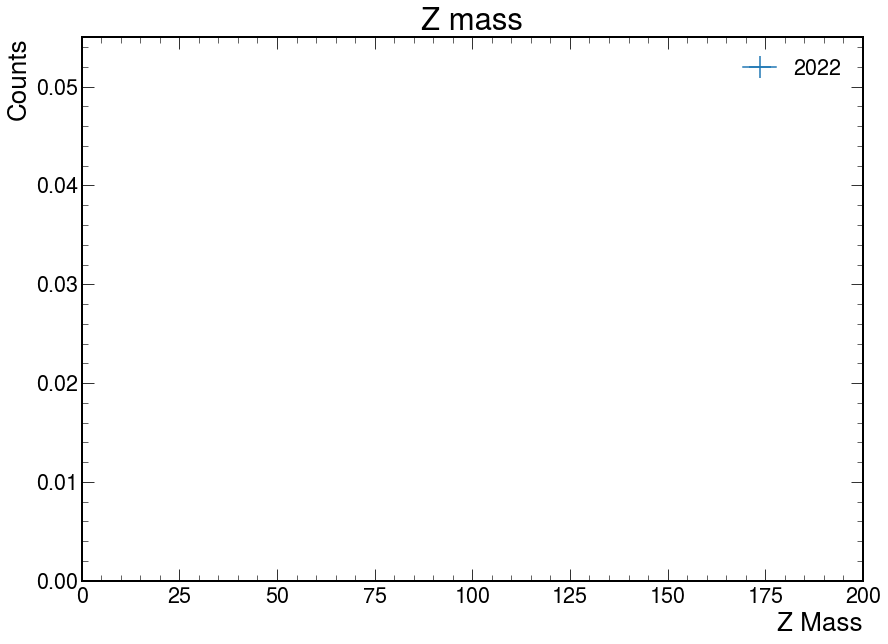

In [38]:
plt.style.use(hep.style.CMS) 
plt.figure(figsize=(14,10))
rechits_axis = hist.Cat("sample", "2022")
ZMass_hist = hist.Hist("Counts", rechits_axis, hist.Bin("ZMass", "Z Mass", 100, 25, 150))
ZMass_hist.fill(sample = '2022', ZMass = events_2022.ZMass)
hist.plot1d(ZMass_hist, density=False)
plt.legend()
plt.title("Z mass")
plt.xlim(0,200)

### Plot Trigger Efficiencies and Other Cluser-by-Cluster Variables

In [41]:
#compute mask for whether a cluster has been matched to a probe muon
matched_clusters_mask = {}
for era in eras:
    one_cluster_mask = np.logical_and(ak.flatten(oneClusterEvents[era].cscRechitCluster_matchToProbeMuon), ak.flatten(oneClusterEvents[era].cscRechitCluster_PassTimeVeto)) 
    one_cluster_mask = np.logical_and(one_cluster_mask, (ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberPlus11)+ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberPlus12)+ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberMinus11)+ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberMinus12)==0))
    many_cluster_mask = np.logical_and(ak.flatten(moreClusterEvents[era].cscRechitCluster_matchToProbeMuon), ak.flatten(moreClusterEvents[era].cscRechitCluster_PassTimeVeto))
    many_cluster_mask = np.logical_and(many_cluster_mask, (ak.flatten(moreClusterEvents[era].cscRechitClusterNRechitChamberPlus11)+ak.flatten(moreClusterEvents[era].cscRechitClusterNRechitChamberPlus12)+ak.flatten(moreClusterEvents[era].cscRechitClusterNRechitChamberMinus11)+ak.flatten(moreClusterEvents[era].cscRechitClusterNRechitChamberMinus12)==0))
    matched_clusters_mask[era] = ak.concatenate([one_cluster_mask, many_cluster_mask])

In [42]:
# load HLT Decisions on a cluster-by-cluster basis
# use HLT decision for one cluster events, computed "prediction" for events with more than one cluster
# apply matched cluster mask

HLT_Loose_Decision = {}
for era in eras:
    HLT_Loose_Decision[era] = ak.mask(ak.concatenate([oneClusterEvents[era].HLT_CscCluster_Loose, ak.flatten(moreClusterEvents[era].cscRechitCluster_HLTCscCluster_Loose_Decision)]), matched_clusters_mask[era])
    HLT_Loose_Decision[era] = HLT_Loose_Decision[era][~ak.is_none(HLT_Loose_Decision[era])]

HLT_Medium_Decision = {}
for era in eras:
    HLT_Medium_Decision[era] = ak.mask(ak.concatenate([oneClusterEvents[era].HLT_CscCluster_Medium, ak.flatten(moreClusterEvents[era].cscRechitCluster_HLTCscCluster_Medium_Decision)]), matched_clusters_mask[era])
    HLT_Medium_Decision[era] = HLT_Medium_Decision[era][~ak.is_none(HLT_Medium_Decision[era])]

HLT_Tight_Decision = {}
for era in eras:
    HLT_Tight_Decision[era] = ak.mask(ak.concatenate([oneClusterEvents[era].HLT_CscCluster_Tight, ak.flatten(moreClusterEvents[era].cscRechitCluster_HLTCscCluster_Tight_Decision)]), matched_clusters_mask[era])
    HLT_Tight_Decision[era] = HLT_Tight_Decision[era][~ak.is_none(HLT_Tight_Decision[era])]

In [43]:
#load rechits, eta, and NStation10
matched_clusters_nhits = {}
for era in eras:
    matched_clusters_nhits[era] = ak.mask(ak.concatenate([ak.flatten(oneClusterEvents[era].cscRechitClusterSize), ak.flatten(moreClusterEvents[era].cscRechitClusterSize)]), matched_clusters_mask[era])
    matched_clusters_nhits[era] = matched_clusters_nhits[era][~ak.is_none(matched_clusters_nhits[era])]
    
matched_clusters_eta = {}
for era in eras:
    matched_clusters_eta[era] = ak.mask(ak.concatenate([ak.flatten(oneClusterEvents[era].cscRechitClusterEta), ak.flatten(moreClusterEvents[era].cscRechitClusterEta)]), matched_clusters_mask[era])
    matched_clusters_eta[era] = matched_clusters_eta[era][~ak.is_none(matched_clusters_eta[era])]
    
matched_clusters_NStation10 = {}
for era in eras:
    matched_clusters_NStation10[era] = ak.mask(ak.concatenate([ak.flatten(oneClusterEvents[era].cscRechitClusterNStation10), ak.flatten(moreClusterEvents[era].cscRechitClusterNStation10)]), matched_clusters_mask[era])
    matched_clusters_NStation10[era] = matched_clusters_NStation10[era][~ak.is_none(matched_clusters_NStation10[era])]

### Efficiencies binned by both Eta and NStation10 (one cluster events only)
#### Bins correspond to categories for which loose, medium, and tight thresholds are set

In [44]:
print(ak.count_nonzero(oneClusterEvents['all'].nCscRechitClusters))
ak.count_nonzero(moreClusterEvents['all'].nCscRechitClusters)

3683599


0

In [45]:
#first, only consider one-cluster data
one_cluster_mask = {}
for era in eras:
    one_cluster_mask[era] = np.logical_and(ak.flatten(oneClusterEvents[era].cscRechitCluster_matchToProbeMuon), ak.flatten(oneClusterEvents[era].cscRechitCluster_PassTimeVeto))
    one_cluster_mask[era] = np.logical_and(one_cluster_mask[era], (ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberPlus11)+ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberPlus12)+ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberMinus11)+ak.flatten(oneClusterEvents[era].cscRechitClusterNRechitChamberMinus12)==0))
    
HLT_Loose_Decision_oneCluster = {}
for era in eras:
    HLT_Loose_Decision_oneCluster[era] = ak.mask(oneClusterEvents[era].HLT_CscCluster_Loose, one_cluster_mask[era])
    HLT_Loose_Decision_oneCluster[era] = HLT_Loose_Decision_oneCluster[era][~ak.is_none(HLT_Loose_Decision_oneCluster[era])]

HLT_Medium_Decision_oneCluster = {}
for era in eras:
    HLT_Medium_Decision_oneCluster[era] = ak.mask(oneClusterEvents[era].HLT_CscCluster_Medium,one_cluster_mask[era])
    HLT_Medium_Decision_oneCluster[era] = HLT_Medium_Decision_oneCluster[era][~ak.is_none(HLT_Medium_Decision_oneCluster[era])]

HLT_Tight_Decision_oneCluster = {}
for era in eras:
    HLT_Tight_Decision_oneCluster[era] = ak.mask(oneClusterEvents[era].HLT_CscCluster_Tight, one_cluster_mask[era])
    HLT_Tight_Decision_oneCluster[era] = HLT_Tight_Decision_oneCluster[era][~ak.is_none(HLT_Tight_Decision_oneCluster[era])]
    
#load rechits, eta, and NStation10
one_cluster_nhits = {}
for era in eras:
    one_cluster_nhits[era] = ak.mask(ak.flatten(oneClusterEvents[era].cscRechitClusterSize), one_cluster_mask[era])
    one_cluster_nhits[era] = one_cluster_nhits[era][~ak.is_none(one_cluster_nhits[era])]
    
one_cluster_eta = {}
for era in eras:
    one_cluster_eta[era] = np.abs(ak.mask(ak.flatten(oneClusterEvents[era].cscRechitClusterEta), one_cluster_mask[era]))
    one_cluster_eta[era] = one_cluster_eta[era][~ak.is_none(one_cluster_eta[era])]
    
one_cluster_NStation10 = {}
for era in eras:
    one_cluster_NStation10[era] = ak.mask(ak.flatten(oneClusterEvents[era].cscRechitClusterNStation10), one_cluster_mask[era])
    one_cluster_NStation10[era] = one_cluster_NStation10[era][~ak.is_none(one_cluster_NStation10[era])]

In [46]:
sample = 'all'
era = sample

In [47]:
#define bins based on eta/NStation10 regions that set trigger thresholds
bins_eta_big = hist.Bin("eta", "eta", np.linspace(0,1.9,1))
bins_NStation10_big= hist.Bin("NStation10", "NStation10", np.linspace(0,1,1))
eta_NStation10_axis = hist.Cat("sample", sample)

In [48]:
#separate data into the correct one of the four eta/NStation10 bins

one_cluster_lowEta_lowNStation10, one_cluster_lowEta_highNStation10, one_cluster_highEta_lowNStation10, one_cluster_highEta_highNStation10 = {},{},{},{}
#era = '2022'
#oneClusterEvents[era] = ak.mask(oneClusterEvents[era], one_cluster_mask[era])

one_cluster_lowEta_lowNStation10['Denominator'] = ak.mask(oneClusterEvents[era],np.logical_and(np.logical_and(ak.flatten(oneClusterEvents[era].cscRechitClusterEta<1.9), ak.flatten(oneClusterEvents[era].cscRechitClusterNStation10<=1)), one_cluster_mask[era]))
one_cluster_lowEta_lowNStation10['Denominator'] = one_cluster_lowEta_lowNStation10["Denominator"][~ak.is_none(one_cluster_lowEta_lowNStation10["Denominator"])]
one_cluster_lowEta_highNStation10['Denominator'] = ak.mask(oneClusterEvents[era],np.logical_and(np.logical_and(ak.flatten(oneClusterEvents[era].cscRechitClusterEta<1.9), ak.flatten(oneClusterEvents[era].cscRechitClusterNStation10>1)), one_cluster_mask[era]))
one_cluster_lowEta_highNStation10['Denominator'] = one_cluster_lowEta_highNStation10["Denominator"][~ak.is_none(one_cluster_lowEta_highNStation10["Denominator"])]
one_cluster_highEta_lowNStation10['Denominator'] = ak.mask(oneClusterEvents[era],np.logical_and(np.logical_and(ak.flatten(oneClusterEvents[era].cscRechitClusterEta>=1.9), ak.flatten(oneClusterEvents[era].cscRechitClusterNStation10<=1)),one_cluster_mask[era]))
one_cluster_highEta_lowNStation10['Denominator'] = one_cluster_highEta_lowNStation10["Denominator"][~ak.is_none(one_cluster_highEta_lowNStation10["Denominator"])]
one_cluster_highEta_highNStation10['Denominator'] = ak.mask(oneClusterEvents[era],np.logical_and(np.logical_and(ak.flatten(oneClusterEvents[era].cscRechitClusterEta>=1.9), ak.flatten(oneClusterEvents[era].cscRechitClusterNStation10>1)),one_cluster_mask[era]))
one_cluster_highEta_highNStation10['Denominator'] = one_cluster_highEta_highNStation10["Denominator"][~ak.is_none(one_cluster_highEta_highNStation10["Denominator"])]

one_cluster_lowEta_lowNStation10['Numerator_Loose'] = ak.mask(one_cluster_lowEta_lowNStation10['Denominator'], one_cluster_lowEta_lowNStation10['Denominator'].HLT_CscCluster_Loose)
one_cluster_lowEta_lowNStation10['Numerator_Loose'] = one_cluster_lowEta_lowNStation10['Numerator_Loose'][~ak.is_none(one_cluster_lowEta_lowNStation10["Numerator_Loose"])]
one_cluster_lowEta_lowNStation10['Numerator_Medium'] = ak.mask(one_cluster_lowEta_lowNStation10['Denominator'], one_cluster_lowEta_lowNStation10['Denominator'].HLT_CscCluster_Medium)
one_cluster_lowEta_lowNStation10['Numerator_Medium'] = one_cluster_lowEta_lowNStation10['Numerator_Medium'][~ak.is_none(one_cluster_lowEta_lowNStation10["Numerator_Medium"])]
one_cluster_lowEta_lowNStation10['Numerator_Tight'] = ak.mask(one_cluster_lowEta_lowNStation10['Denominator'], one_cluster_lowEta_lowNStation10['Denominator'].HLT_CscCluster_Tight)
one_cluster_lowEta_lowNStation10['Numerator_Tight'] = one_cluster_lowEta_lowNStation10['Numerator_Tight'][~ak.is_none(one_cluster_lowEta_lowNStation10["Numerator_Tight"])]

one_cluster_lowEta_highNStation10['Numerator_Loose'] = ak.mask(one_cluster_lowEta_highNStation10['Denominator'], one_cluster_lowEta_highNStation10['Denominator'].HLT_CscCluster_Loose)
one_cluster_lowEta_highNStation10['Numerator_Loose'] = one_cluster_lowEta_highNStation10['Numerator_Loose'][~ak.is_none(one_cluster_lowEta_highNStation10["Numerator_Loose"])]
one_cluster_lowEta_highNStation10['Numerator_Medium'] = ak.mask(one_cluster_lowEta_highNStation10['Denominator'], one_cluster_lowEta_highNStation10['Denominator'].HLT_CscCluster_Medium)
one_cluster_lowEta_highNStation10['Numerator_Medium'] = one_cluster_lowEta_highNStation10['Numerator_Medium'][~ak.is_none(one_cluster_lowEta_highNStation10["Numerator_Medium"])]
one_cluster_lowEta_highNStation10['Numerator_Tight'] = ak.mask(one_cluster_lowEta_highNStation10['Denominator'], one_cluster_lowEta_highNStation10['Denominator'].HLT_CscCluster_Tight)
one_cluster_lowEta_highNStation10['Numerator_Tight'] = one_cluster_lowEta_highNStation10['Numerator_Tight'][~ak.is_none(one_cluster_lowEta_highNStation10["Numerator_Tight"])]

one_cluster_highEta_lowNStation10['Numerator_Loose'] = ak.mask(one_cluster_highEta_lowNStation10['Denominator'], one_cluster_highEta_lowNStation10['Denominator'].HLT_CscCluster_Loose)
one_cluster_highEta_lowNStation10['Numerator_Loose'] = one_cluster_highEta_lowNStation10['Numerator_Loose'][~ak.is_none(one_cluster_highEta_lowNStation10["Numerator_Loose"])]
one_cluster_highEta_lowNStation10['Numerator_Medium'] = ak.mask(one_cluster_highEta_lowNStation10['Denominator'], one_cluster_highEta_lowNStation10['Denominator'].HLT_CscCluster_Medium)
one_cluster_highEta_lowNStation10['Numerator_Medium'] = one_cluster_highEta_lowNStation10['Numerator_Medium'][~ak.is_none(one_cluster_highEta_lowNStation10["Numerator_Medium"])]
one_cluster_highEta_lowNStation10['Numerator_Tight'] = ak.mask(one_cluster_highEta_lowNStation10['Denominator'], one_cluster_highEta_lowNStation10['Denominator'].HLT_CscCluster_Tight)
one_cluster_highEta_lowNStation10['Numerator_Tight'] = one_cluster_highEta_lowNStation10['Numerator_Tight'][~ak.is_none(one_cluster_highEta_lowNStation10["Numerator_Tight"])]

one_cluster_highEta_highNStation10['Numerator_Loose'] = ak.mask(one_cluster_highEta_highNStation10['Denominator'], one_cluster_highEta_highNStation10['Denominator'].HLT_CscCluster_Loose)
one_cluster_highEta_highNStation10['Numerator_Loose'] = one_cluster_highEta_highNStation10['Numerator_Loose'][~ak.is_none(one_cluster_highEta_highNStation10["Numerator_Loose"])]
one_cluster_highEta_highNStation10['Numerator_Medium'] = ak.mask(one_cluster_highEta_highNStation10['Denominator'], one_cluster_highEta_highNStation10['Denominator'].HLT_CscCluster_Medium)
one_cluster_highEta_highNStation10['Numerator_Medium'] = one_cluster_highEta_highNStation10['Numerator_Medium'][~ak.is_none(one_cluster_highEta_highNStation10["Numerator_Medium"])]
one_cluster_highEta_highNStation10['Numerator_Tight'] = ak.mask(one_cluster_highEta_highNStation10['Denominator'], one_cluster_highEta_highNStation10['Denominator'].HLT_CscCluster_Tight)
one_cluster_highEta_highNStation10['Numerator_Tight'] = one_cluster_highEta_highNStation10['Numerator_Tight'][~ak.is_none(one_cluster_highEta_highNStation10["Numerator_Tight"])]


In [58]:
# from statsmodels.stats.proportion import proportion_confint
# num_rows = 1
# num_cols = 3
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
# fig.suptitle("L1+HLT Combined Efficiency for " + sample + " One-Cluster Events")
# thresholds = ["Loose", "Medium", "Tight"]


# matrix_loose = np.array([
#         [round(ak.count(one_cluster_lowEta_highNStation10['Numerator_Loose'])/ak.count(one_cluster_lowEta_highNStation10['Denominator']),4), round(ak.count(one_cluster_highEta_highNStation10['Numerator_Loose'])/ak.count(one_cluster_highEta_highNStation10['Denominator']),4)],
#         [round(ak.count(one_cluster_lowEta_lowNStation10['Numerator_Loose'])/ak.count(one_cluster_lowEta_lowNStation10['Denominator']),4), round(ak.count(one_cluster_highEta_lowNStation10['Numerator_Loose'])/ak.count(one_cluster_highEta_lowNStation10['Denominator']),4)]
#     ])
# matrix_loose_errors = np.array([
#         [proportion_confint(ak.count(one_cluster_lowEta_highNStation10['Numerator_Loose']),ak.count(one_cluster_lowEta_highNStation10['Denominator']), alpha=0.05, method='beta'), proportion_confint(ak.count(one_cluster_highEta_highNStation10['Numerator_Loose']),ak.count(one_cluster_highEta_highNStation10['Denominator']), alpha=0.05, method='beta')],
#         [proportion_confint(ak.count(one_cluster_lowEta_lowNStation10['Numerator_Loose']),ak.count(one_cluster_lowEta_lowNStation10['Denominator']), alpha=0.05, method='beta'), proportion_confint(ak.count(one_cluster_highEta_lowNStation10['Numerator_Loose']),ak.count(one_cluster_highEta_lowNStation10['Denominator']), alpha=0.05, method='beta')]
#     ])

# matrix_medium = np.array([
#         [round(ak.count(one_cluster_lowEta_highNStation10['Numerator_Medium'])/ak.count(one_cluster_lowEta_highNStation10['Denominator']),4), round(ak.count(one_cluster_highEta_highNStation10['Numerator_Medium'])/ak.count(one_cluster_highEta_highNStation10['Denominator']),4)],
#         [round(ak.count(one_cluster_lowEta_lowNStation10['Numerator_Medium'])/ak.count(one_cluster_lowEta_lowNStation10['Denominator']),4), round(ak.count(one_cluster_highEta_lowNStation10['Numerator_Medium'])/ak.count(one_cluster_highEta_lowNStation10['Denominator']),4)]
#     ])
# matrix_medium_errors = np.array([
#         [proportion_confint(ak.count(one_cluster_lowEta_highNStation10['Numerator_Medium']),ak.count(one_cluster_lowEta_highNStation10['Denominator']), alpha=0.05, method='beta'), proportion_confint(ak.count(one_cluster_highEta_highNStation10['Numerator_Medium']),ak.count(one_cluster_highEta_highNStation10['Denominator']), alpha=0.05, method='beta')],
#         [proportion_confint(ak.count(one_cluster_lowEta_lowNStation10['Numerator_Medium']),ak.count(one_cluster_lowEta_lowNStation10['Denominator']), alpha=0.05, method='beta'), proportion_confint(ak.count(one_cluster_highEta_lowNStation10['Numerator_Medium']),ak.count(one_cluster_highEta_lowNStation10['Denominator']), alpha=0.05, method='beta')]
#     ])

# matrix_tight = np.array([
#         [round(ak.count(one_cluster_lowEta_highNStation10['Numerator_Tight'])/ak.count(one_cluster_lowEta_highNStation10['Denominator']),4), round(ak.count(one_cluster_highEta_highNStation10['Numerator_Tight'])/ak.count(one_cluster_highEta_highNStation10['Denominator']),4)],
#         [round(ak.count(one_cluster_lowEta_lowNStation10['Numerator_Tight'])/ak.count(one_cluster_lowEta_lowNStation10['Denominator']),4), round(ak.count(one_cluster_highEta_lowNStation10['Numerator_Tight'])/ak.count(one_cluster_highEta_lowNStation10['Denominator']),4)]
#     ])
# matrix_tight_errors = np.array([
#         [proportion_confint(ak.count(one_cluster_lowEta_highNStation10['Numerator_Tight']),ak.count(one_cluster_lowEta_highNStation10['Denominator']), alpha=0.05, method='beta'), proportion_confint(ak.count(one_cluster_highEta_highNStation10['Numerator_Tight']),ak.count(one_cluster_highEta_highNStation10['Denominator']), alpha=0.05, method='beta')],
#         [proportion_confint(ak.count(one_cluster_lowEta_lowNStation10['Numerator_Tight']),ak.count(one_cluster_lowEta_lowNStation10['Denominator']), alpha=0.05, method='beta'), proportion_confint(ak.count(one_cluster_highEta_lowNStation10['Numerator_Tight']),ak.count(one_cluster_highEta_lowNStation10['Denominator']), alpha=0.05, method='beta')]
#     ])
# matrices_efficiencies = {"Loose": matrix_loose, "Medium": matrix_medium, "Tight": matrix_tight}
# matrices_intervals = {"Loose": matrix_loose_errors, "Medium": matrix_medium_errors, "Tight": matrix_tight_errors}


# for idx, threshold_name in enumerate(thresholds):
#     row = idx // num_cols
#     col = idx % num_cols
    
#     axes[col].imshow(matrices_efficiencies[threshold_name], cmap=plt.cm.Blues, vmax=0.2)
#     #axes.set_title(subkey)
#     axes[col].set_title(threshold_name)
#     axes[col].set_xlabel('eta')
#     axes[col].set_ylabel('NStation10')
#     axes[col].set_xticks([0.5])
#     axes[col].set_yticks([0.5])

#     # Set tick labels
#     axes[col].set_xticklabels(['1.9'])
#     axes[col].set_yticklabels(['1'])

#     for i in range(2):
#         for j in range(2):
#             axes[col].text(j, i, str(matrices_efficiencies[threshold_name][i, j]), ha='center', va='center', color='black', fontsize=20)
#             axes[col].text(j, i, '\n\n[' + str(round(matrices_intervals[threshold_name][i,j][0],4)) + ", " + str(round(matrices_intervals[threshold_name][i,j][1],4)) + ']', ha='center', va='center', color='black', fontsize=14)
# plt.subplots_adjust(top=0.7)
# plt.show()

### Now, make the same cluster size vs efficiency plots on a bin by bin basis

In [49]:
bins_rechits_lowEta_lowNStation10 = hist.Bin("cluster_size", "Cluster Size", np.concatenate([np.arange(0, 200, 20), np.arange(200, 1000, 100)]))
bins_rechits_lowEta_highNStation10 = hist.Bin("cluster_size", "Cluster Size", np.concatenate([np.arange(0, 100, 20), np.arange(100, 1000, 100)]))
rechits_axis = hist.Cat("sample", sample)


In [50]:
def make_plots_hits_efficiency(data, title, bins):
    plt.style.use(hep.style.CMS) 
    num_rows = 1
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 8 * num_rows))
    fig.suptitle(sample + " " + title)
    rechits_hist = hist.Hist("Counts", rechits_axis, bins)
    arr_to_plot = ak.flatten(data["Denominator"].cscRechitClusterSize)
    rechits_hist.fill(sample = f"2022 - {ak.count(arr_to_plot)} entries", cluster_size=arr_to_plot)
    hist.plot1d(rechits_hist, density=False, ax = axes[0])
    axes[0].legend()
    axes[0].set_title("Z -> mu mu + MDS Events", fontsize=24)
    axes[0].set_xlim(0,400)
    axes[0].set_xlabel("Cluster Size", fontsize=20)
    axes[0].set_ylabel("Counts", fontsize=20)
    

    rechits_hist_HLTLoose = hist.Hist("Counts", rechits_axis, bins)
    arr_to_plot = ak.flatten(data["Numerator_Loose"].cscRechitClusterSize)
    rechits_hist_HLTLoose.fill(sample = f"Loose - {ak.count(arr_to_plot)} entries", cluster_size=arr_to_plot)
    hist.plot1d(rechits_hist_HLTLoose, density=False, ax=axes[1], clear=False)

    '''
    rechits_hist_HLTMedium = hist.Hist("Counts", rechits_axis, bins_rechits)
    arr_to_plot = ak.flatten(data["Numerator_Medium"].cscRechitClusterSize)
    rechits_hist_HLTMedium.fill(sample = f"Medium - {ak.count(arr_to_plot)} entries", cluster_size=arr_to_plot)
    hist.plot1d(rechits_hist_HLTMedium, density=False, ax=axes[1],clear=False)

    rechits_hist_HLTTight = hist.Hist("Counts", rechits_axis, bins_rechits)
    arr_to_plot = ak.flatten(data["Numerator_Tight"].cscRechitClusterSize)
    rechits_hist_HLTTight.fill(sample = f"Tight - {ak.count(arr_to_plot)} entries", cluster_size=arr_to_plot)
    hist.plot1d(rechits_hist_HLTTight, density=False, ax=axes[1], clear=False)
    '''
    
    axes[1].set_title("Z -> mu mu + MDS + Fire HLT Events", fontsize=24)
    axes[1].legend()
    axes[1].set_xlabel("Cluster Size", fontsize=20)
    axes[1].set_ylabel("Counts", fontsize=20)
    import matplotlib
    
    hist.plotratio(
                ax=axes[2],
                num  =rechits_hist_HLTLoose.project(bins),
                denom=rechits_hist.project(bins),
                error_opts={'marker': '.'},
                unc='clopper-pearson',
                label= "Loose",
                clear=False
            )
    '''
    hist.plotratio(
                ax=axes[2],
                num  =rechits_hist_HLTMedium.project(bins_rechits),
                denom=rechits_hist.project(bins_rechits),
                error_opts={'marker': '.'},
                unc='clopper-pearson',
                label= "Medium",
                clear=False
            )

    hist.plotratio(
                ax=axes[2],
                num  =rechits_hist_HLTTight.project(bins_rechits),
                denom=rechits_hist.project(bins_rechits),
                error_opts={'marker': '.'},
                unc='clopper-pearson',
                label= "Tight",
                clear=False
            )
    '''
    axes[2].legend()
    axes[2].set_title("Efficiency vs Cluster Size", fontsize=24)
    axes[2].set_xlabel("Cluster Size", fontsize=20)
    axes[2].set_ylabel("L1+HLT Efficiency", fontsize=20)
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


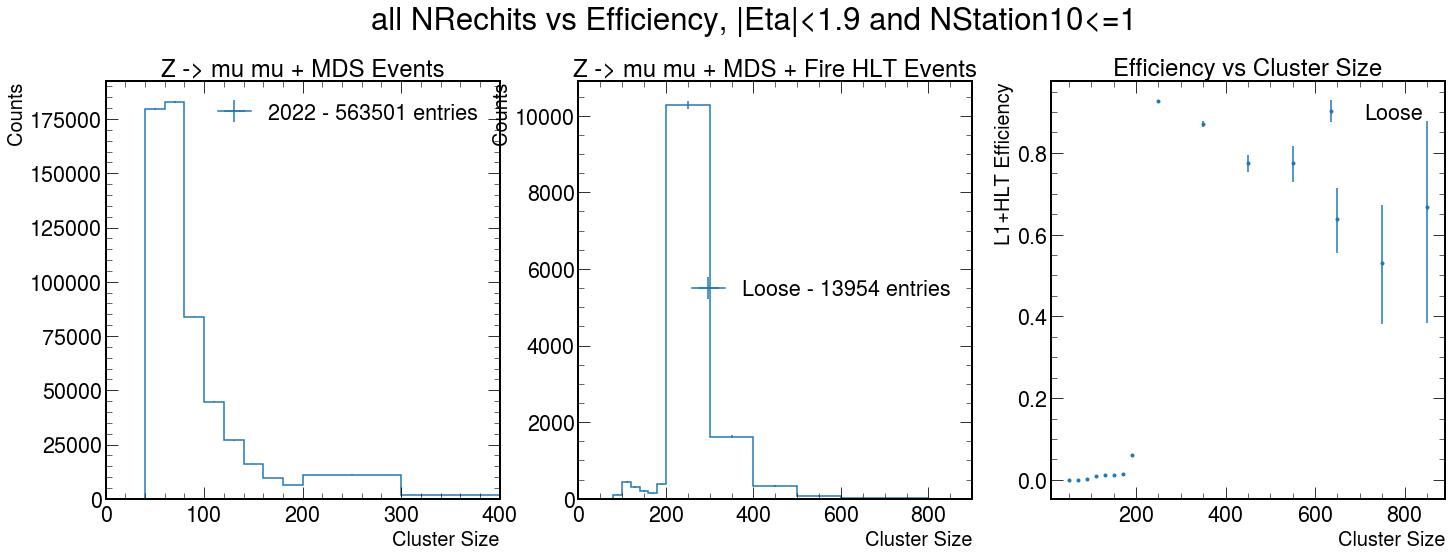

In [51]:
make_plots_hits_efficiency(data=one_cluster_lowEta_lowNStation10, title="NRechits vs Efficiency, |Eta|<1.9 and NStation10<=1",
                          bins=bins_rechits_lowEta_lowNStation10)

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


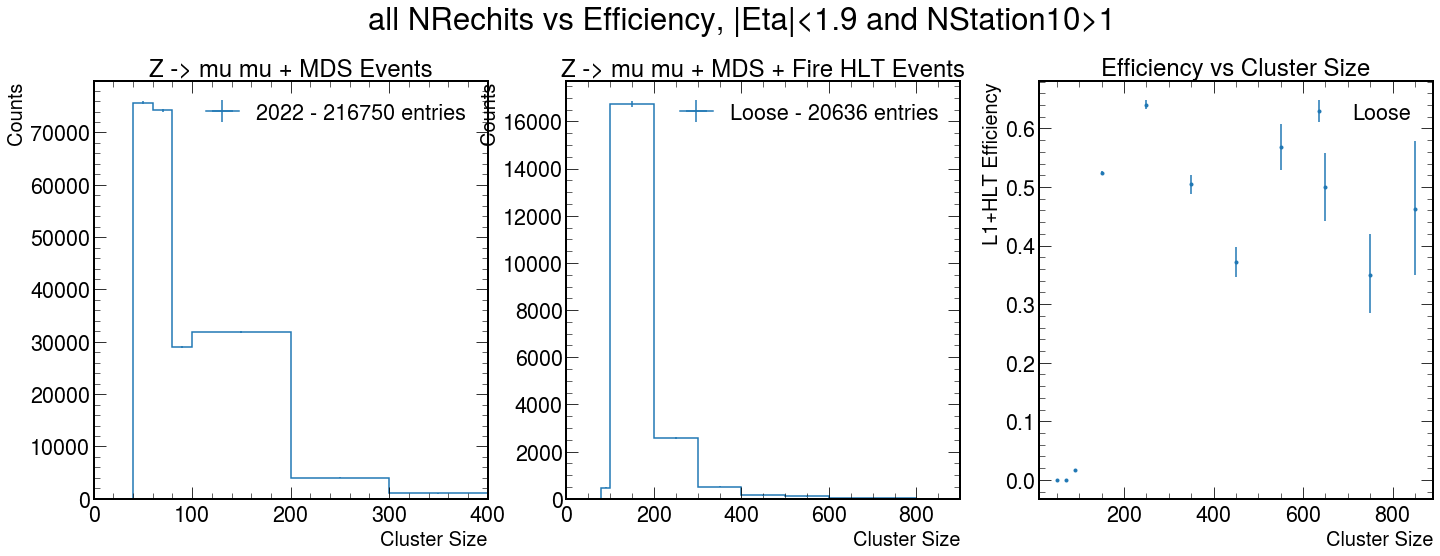

In [52]:
make_plots_hits_efficiency(data=one_cluster_lowEta_highNStation10, title="NRechits vs Efficiency, |Eta|<1.9 and NStation10>1",
                          bins=bins_rechits_lowEta_highNStation10)

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


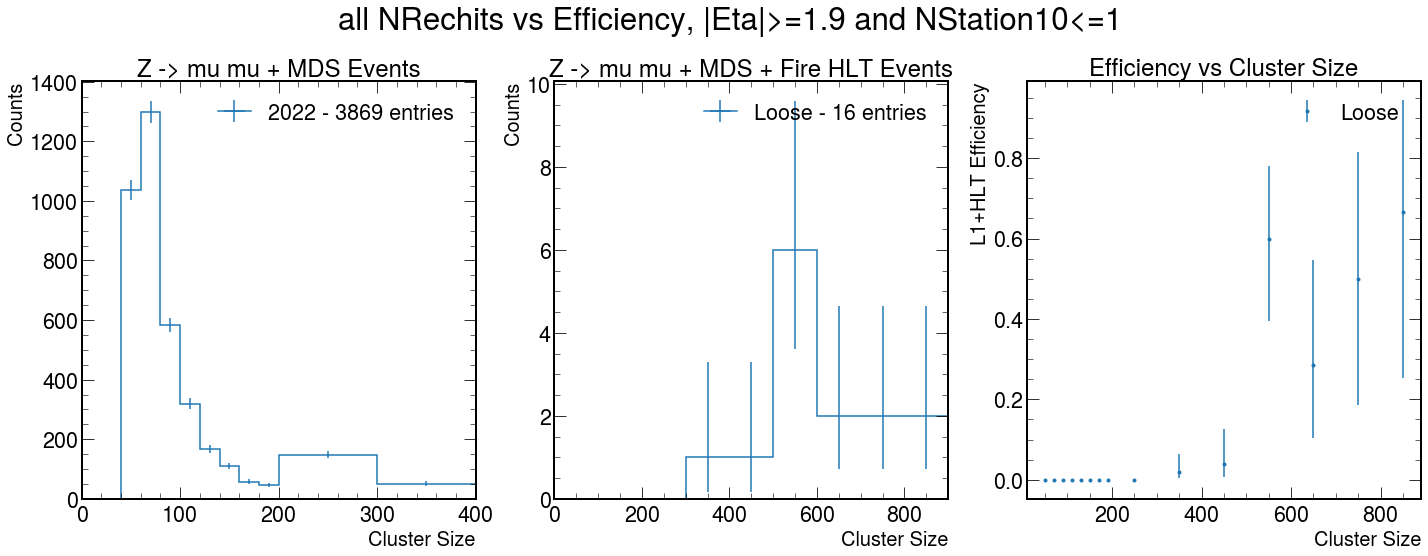

In [53]:
make_plots_hits_efficiency(data=one_cluster_highEta_lowNStation10, title="NRechits vs Efficiency, |Eta|>=1.9 and NStation10<=1",
                          bins=bins_rechits_lowEta_lowNStation10)

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


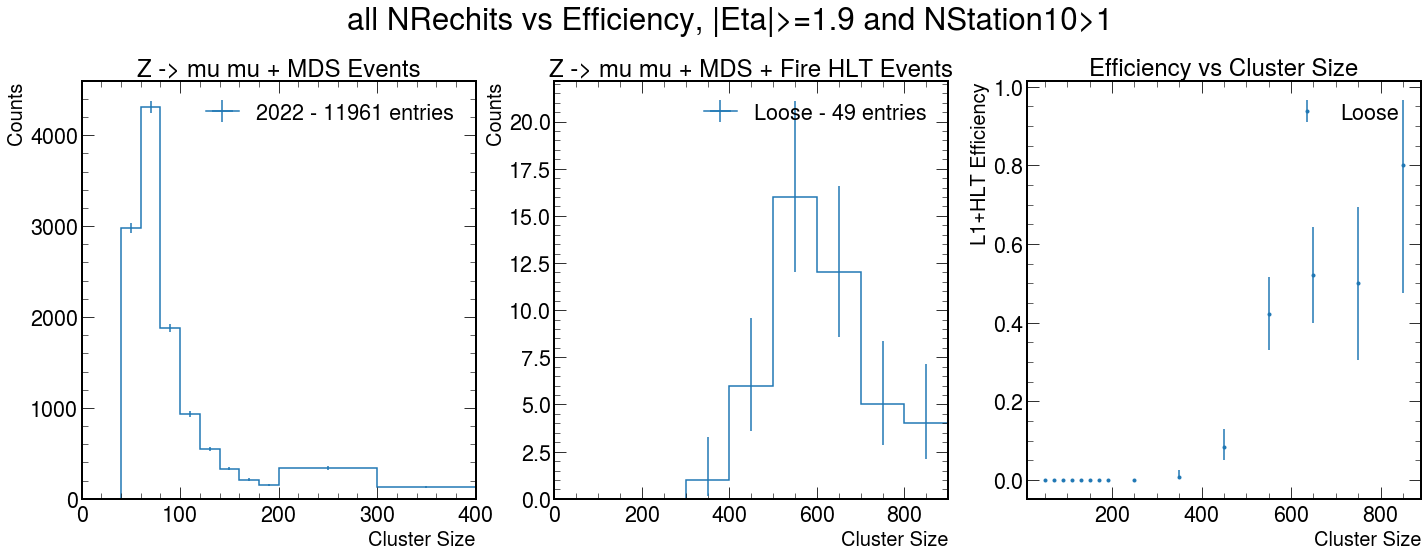

In [54]:
make_plots_hits_efficiency(data=one_cluster_highEta_highNStation10, title="NRechits vs Efficiency, |Eta|>=1.9 and NStation10>1",
                          bins=bins_rechits_lowEta_lowNStation10)

### L1 Efficiency by Chamber

In [55]:
chamber_locations = {
    "ME11": {"MinR": 100, "MaxR": 275, "minZ": 580, "maxZ": 632, "HLT_thresh": 500, "branch_names": ["cscRechitClusterNRechitChamberMinus11", "cscRechitClusterNRechitChamberPlus11"]},
    "ME12": {"MinR": 275, "MaxR": 465, "minZ": 668, "maxZ": 725, "HLT_thresh": 200, "branch_names": ["cscRechitClusterNRechitChamberMinus12", "cscRechitClusterNRechitChamberPlus12"]},
    "ME13": {"MinR": 505, "MaxR": 700, "minZ": 668, "maxZ": 724, "HLT_thresh": 200, "branch_names": ["cscRechitClusterNRechitChamberMinus13", "cscRechitClusterNRechitChamberPlus13"]},
    "ME21": {"MinR": 139, "MaxR": 345, "minZ": 789, "maxZ": 850, "HLT_thresh": 500, "branch_names": ["cscRechitClusterNRechitChamberMinus21", "cscRechitClusterNRechitChamberPlus21"]},
    "ME22": {"MinR": 357, "MaxR": 700, "minZ": 791, "maxZ": 850, "HLT_thresh": 200, "branch_names": ["cscRechitClusterNRechitChamberMinus22", "cscRechitClusterNRechitChamberPlus22"]},
    "ME31": {"MinR": 160, "MaxR": 345, "minZ": 915, "maxZ": 970, "HLT_thresh": 500, "branch_names": ["cscRechitClusterNRechitChamberMinus31", "cscRechitClusterNRechitChamberPlus31"]},
    "ME32": {"MinR": 357, "MaxR": 700, "minZ": 911, "maxZ": 970, "HLT_thresh": 200, "branch_names": ["cscRechitClusterNRechitChamberMinus32", "cscRechitClusterNRechitChamberPlus32"]},
    "ME41": {"MinR": 178, "MaxR": 345, "minZ": 1002, "maxZ": 1063, "HLT_thresh": 500, "branch_names": ["cscRechitClusterNRechitChamberMinus41", "cscRechitClusterNRechitChamberPlus41"]},
    "ME42": {"MinR": 357, "MaxR": 700, "minZ": 1002, "maxZ": 1063, "HLT_thresh": 200, "branch_names": ["cscRechitClusterNRechitChamberMinus42", "cscRechitClusterNRechitChamberPlus42"]}
}

In [56]:
nRechits_branches = ["cscRechitClusterNRechitChamberMinus11", "cscRechitClusterNRechitChamberPlus11", "cscRechitClusterNRechitChamberMinus12", "cscRechitClusterNRechitChamberPlus12",
                    "cscRechitClusterNRechitChamberMinus13", "cscRechitClusterNRechitChamberPlus13", "cscRechitClusterNRechitChamberMinus21", "cscRechitClusterNRechitChamberPlus21",
                    "cscRechitClusterNRechitChamberMinus22", "cscRechitClusterNRechitChamberPlus22", "cscRechitClusterNRechitChamberMinus31", "cscRechitClusterNRechitChamberPlus31",
                    "cscRechitClusterNRechitChamberMinus32", "cscRechitClusterNRechitChamberPlus32", "cscRechitClusterNRechitChamberMinus41", "cscRechitClusterNRechitChamberPlus41",
                    "cscRechitClusterNRechitChamberMinus42", "cscRechitClusterNRechitChamberPlus42"]

In [57]:
chambers = ["ME11", "ME12", "ME13", "ME21", "ME22", "ME31", "ME32", "ME41", "ME42"]

In [58]:
# plt.style.use(hep.style.CMS) 
# import matplotlib
# num_rows = 3
# num_cols = 3
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 8 * num_rows))
# fig.suptitle("2022 + 2023" + " L1 Efficiencies from HLT_IsoMuon24 Control Sample")
# sample = "all"
# bins = bins_rechits_lowEta_lowNStation10
# chambers = ["ME11", "ME12", "ME13", "ME21", "ME22", "ME31", "ME32", "ME41", "ME42"]
# counter = 0
# for i in range(num_rows):
#     for j in range(num_cols):
#         #chamber = list(chamber_locations.keys())[counter]
#         chamber = chambers[counter]
#         chamber_int = int(chamber[2:])
        
#         #maskZ = np.logical_and(abs(ak.flatten(oneClusterEvents[sample].cscRechitClusterZ))>chamber_locations[chamber]["minZ"], abs(ak.flatten(oneClusterEvents[sample].cscRechitClusterZ))<chamber_locations[chamber]["maxZ"])
#         #maskR = ak.flatten(np.logical_and((np.sqrt(oneClusterEvents[sample].cscRechitClusterX**2+oneClusterEvents[sample].cscRechitClusterY**2))>chamber_locations[chamber]["MinR"], (np.sqrt(oneClusterEvents[sample].cscRechitClusterX**2+oneClusterEvents[sample].cscRechitClusterY**2))<chamber_locations[chamber]["MaxR"]))
#         #total_mask = np.logical_and(np.logical_and(maskZ, maskR), ak.flatten(oneClusterEvents[sample]["cscRechitClusterNStation10"]==1))
        
#         total_mask = compute_chamber_mask(oneClusterEvents[sample], chamber, chamber_int, 0.9)
#         denom = ak.mask(ak.flatten(oneClusterEvents[sample].cscRechitClusterSize), total_mask)
        
#         num = ak.mask(denom, ak.mask(np.logical_or(oneClusterEvents[sample].L1_SingleMuShower_Nominal, oneClusterEvents[sample].L1_SingleMuShower_Tight),total_mask))
#         denom = denom[~ak.is_none(denom)]
#         num = num[~ak.is_none(num)]
#         counter+=1
#         axes[i,j].set_title(chamber, fontsize=24)
#         axes[i,j].axvline(chamber_locations[chamber]["HLT_thresh"], color="black", label="HLT Threshold")
#         if ak.count(denom)==0: 
#             axes[i][j].set_xlabel("Cluster Size", fontsize=20)
#             axes[i,j].set_ylabel("L1 Efficiency", fontsize=20)
#             axes[i,j].set_xlim(0,900)
#             continue
#         num_hist = hist.Hist("Counts", rechits_axis, bins)
#         arr_to_fill = num
#         num_hist.fill(sample = f"{ak.count(arr_to_fill)} entries", cluster_size=arr_to_fill)
        
#         denom_hist = hist.Hist("Counts", rechits_axis, bins)
#         arr_to_fill = denom
#         denom_hist.fill(sample = f"{ak.count(arr_to_fill)} entries", cluster_size=arr_to_fill)
#         print(chamber + " ", ak.count(denom))
#         hist.plotratio(
#                     ax=axes[i,j],
#                     num =num_hist.project(bins),
#                     denom=denom_hist.project(bins),
#                     error_opts={'marker': '.'},
#                     unc='clopper-pearson',
#                     label= "L1 Efficiency",
#                     clear=False
#                 )
#         '''
#         hist.plotratio(
#                     ax=axes[2],
#                     num  =rechits_hist_HLTMedium.project(bins_rechits),
#                     denom=rechits_hist.project(bins_rechits),
#                     error_opts={'marker': '.'},
#                     unc='clopper-pearson',
#                     label= "Medium",
#                     clear=False
#                 )

#         hist.plotratio(
#                     ax=axes[2],
#                     num  =rechits_hist_HLTTight.project(bins_rechits),
#                     denom=rechits_hist.project(bins_rechits),
#                     error_opts={'marker': '.'},
#                     unc='clopper-pearson',
#                     label= "Tight",
#                     clear=False
#                 )
#         '''
#         axes[i,j].legend()
#         #axes[i,j].set_title(chamber, fontsize=24)
#         axes[i][j].set_xlabel("Cluster Size", fontsize=20)
#         axes[i,j].set_ylabel("L1 Efficiency", fontsize=20)
        
# plt.subplots_adjust(top=0.93)
# plt.savefig("L1_Efficiencies.png")
# plt.show()


### Code to Make Plots for Paper
Define function to return efficiency histogram for 2022, 2023, and combined 

In [59]:
#code to mask for clusters for which majority of events are in designated chamber
#require greater than 90% of hits to be in given chamber as well
def compute_chamber_mask(data, chamber, chamber_int, threshold, endcap=None):
    nRechits_byChamber = {}
    final_masks = []
    for x in range(2):
        correct_chamber_branch = chamber_locations[chamber]["branch_names"][x]
        incorrect_chamber_branches = []
        for chamber_branch in nRechits_branches:
            if chamber_branch != correct_chamber_branch:
                incorrect_chamber_branches.append(chamber_branch)         
        mask = ak.flatten(data[correct_chamber_branch])>ak.flatten(data[incorrect_chamber_branches[0]])
        for idx in range(1, len(incorrect_chamber_branches)):
            mask = np.logical_and(mask, ak.flatten(data[correct_chamber_branch])>ak.flatten(data[incorrect_chamber_branches[idx]]))
        mask = np.logical_and(mask, (ak.flatten(data[correct_chamber_branch])/ak.flatten(data["cscRechitClusterSize"])>=threshold))
        #code to mask out negative endcap clusters in problematic region
        #if x==0 and (chamber=="ME31" or chamber=="ME41"):
        #    mask = np.logical_and(mask, np.logical_not(noisy_cluster_events(data)))
        #print(ak.count_nonzero(mask))
        final_masks.append(mask)
    if endcap==None:
        return np.logical_or(final_masks[0], final_masks[1])
    else:
        return final_masks[endcap]

In [60]:
def noisy_cluster_events(data):
    #return (np.abs(ak.flatten(data.cscRechitClusterPhi))<0.2) & (ak.flatten(data.cscRechitClusterEta < -2)) & (ak.flatten(data.cscRechitClusterZ < -900)) & (data.runNum >367079)
    return (np.abs(ak.flatten(data.cscRechitClusterPhi))>3) & (ak.flatten(data.cscRechitClusterEta < -1.9))
    #return ((ak.flatten(data.cscRechitClusterPhi)>0.4) & (ak.flatten(data.cscRechitClusterPhi)<0.8)) | (ak.flatten(data.cscRechitClusterPhi)<-3)

In [61]:
#function to to return ratio histograms
def get_efficiency_hists(data, chamber, bins, endcap=None):
    total_mask = compute_chamber_mask(data, chamber, chamber_int, 0.9, endcap)
    
    #COMMENT OUT WHEN NOT DOING NOISE MASK INVERSION
    #total_mask = np.logical_and(total_mask, noisy_cluster_events(data))
    
    denom = ak.mask(ak.flatten(data.cscRechitClusterSize), total_mask)
    num = ak.mask(denom, ak.mask(np.logical_or(data.L1_SingleMuShower_Nominal, data.L1_SingleMuShower_Tight),total_mask))
    denom = denom[~ak.is_none(denom)]
    num = num[~ak.is_none(num)]
    print(len(num))
    print(len(denom))
    
    num_hist = hist.Hist("Counts", rechits_axis, bins, xerr=True)
    arr_to_fill = num
    num_hist.fill(sample = f"{ak.count(arr_to_fill)} entries", cluster_size=arr_to_fill)

    denom_hist = hist.Hist("Counts", rechits_axis, bins)
    arr_to_fill = denom
    denom_hist.fill(sample = f"{ak.count(arr_to_fill)} entries", cluster_size=arr_to_fill)

    return num_hist, denom_hist


In [62]:
colors = ["green", "red", "black"]
#colors = ["black"]
center_of_mass_energy = 13.6

In [63]:
#breakpoint

In [64]:
np.abs(ak.flatten(oneClusterEvents['all'].cscRechitClusterPhi))<0.2

<Array [False, False, False, ... False, False] type='3683599 * bool'>

### Scratch Work - Finding Runs with Extraneous hits (high eta in negative endcap, phi near 0)

In [65]:
runs_bins = hist.Bin("run_nums", "Run Numbers", np.concatenate([np.array(range(360019, 366726+1, 300)), np.array(range(366727, 367079+1, 100)),np.array(range(367080, 370790+1, 300))]))

In [66]:
np.linspace(366727, 367079+1, 2)

array([366727., 367080.])

In [67]:
num = ak.mask(oneClusterEvents['all'].runNum, ((np.abs(ak.flatten(oneClusterEvents['all'].cscRechitClusterPhi))<0.2) & (ak.flatten(oneClusterEvents['all'].cscRechitClusterEta < -2)) & (ak.flatten(oneClusterEvents['all'].cscRechitClusterZ < -900)) &  (ak.flatten(oneClusterEvents['all'].cscRechitClusterSize > cluster_size_threshold))))
num = num[~ak.is_none(num)]
ak.count_nonzero(num[(num>366727) & (num<367079)])

NameError: name 'cluster_size_threshold' is not defined

In [68]:
#numerator: number of clusters with phi near 0 and phi at high value in given run bin
#denominator: number of cluster in given run bin
cluster_size_threshold=0
num = ak.mask(oneClusterEvents['all'].runNum, ((np.abs(ak.flatten(oneClusterEvents['all'].cscRechitClusterPhi))<0.2) & (ak.flatten(oneClusterEvents['all'].cscRechitClusterEta < -2)) & (ak.flatten(oneClusterEvents['all'].cscRechitClusterZ < -900)) &  (ak.flatten(oneClusterEvents['all'].cscRechitClusterSize > cluster_size_threshold))))
num = num[~ak.is_none(num)]
#denom = oneClusterEvents['all'].runNum
denom = ak.mask(oneClusterEvents['all'].runNum, ak.flatten(oneClusterEvents['all'].cscRechitClusterEta < 0))
denom = denom[~ak.is_none(denom)]
runs_axis = hist.Cat("sample", "sample")
run_hist_num = hist.Hist("Counts", runs_axis, runs_bins)
run_hist_denom = hist.Hist("Counts", runs_axis, runs_bins)
run_hist_num.fill(sample = f"2022+2023 run nums", run_nums=num)
run_hist_denom.fill(sample = f"2022+2023 run nums", run_nums=denom)

In [69]:
ak.count_nonzero(denom[(num>366727) & (num<367079)])

323

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


Text(0, 1, 'Noisy Cluster Ratio: Negative Endcap')

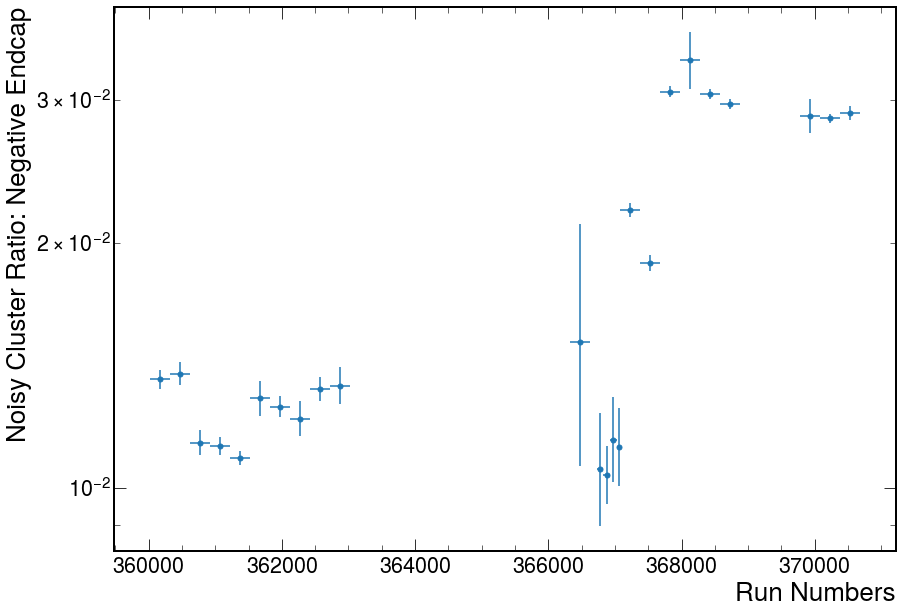

In [70]:
plt.style.use(hep.style.CMS) 
plt.figure(figsize=(14,10))
plt.yscale("log")
hist.plotratio(
        ax=plt.gca(),
        num = run_hist_num.project(runs_bins),
        denom=run_hist_denom.project(runs_bins),
        error_opts={'marker': '.', 'markersize': 10},
        unc='clopper-pearson',
        label= "2022+2023",
        clear=False,
        xerr=True
        )
plt.ylabel("Noisy Cluster Ratio: Negative Endcap")
# plt.axvline(366727, color='purple')
# plt.axvline(367079, color='purple')
# plt.axvline(367095, color='red')
# plt.axvline(368822, color='red')

### ME11

In [74]:
myString = "_NEWMERGECorrect_separate_years_mask_phi>0"
chamber_int=0

In [75]:
bins_ME11 = hist.Bin("cluster_size", "Cluster Size", np.concatenate([np.arange(0, 200, 20), np.arange(200, 1000, 100)]))

0
0


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


0
0


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


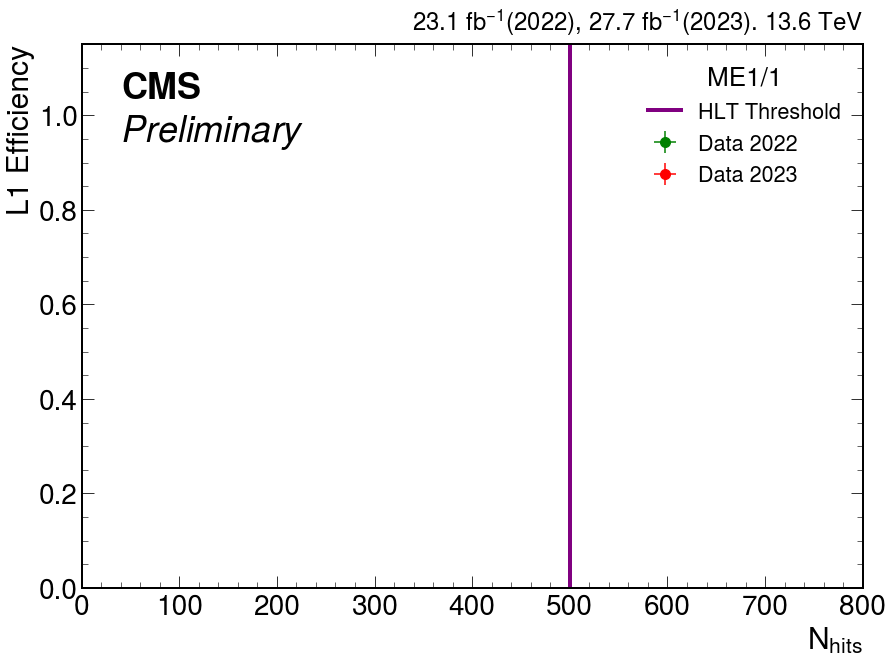

In [76]:
plt.figure(figsize=(14,10))
chamber="ME11"
chamber_with_slash = chamber[:3] + '/' + chamber[3]
bins = bins_ME11
for num, sample in enumerate(['2022', '2023']):
    if sample=='all':
        labelName = '2022 + 2023'
    else:
        labelName = sample
    if num==0:
        plt.axvline(chamber_locations[chamber]["HLT_thresh"], color="purple", label="HLT Threshold", linewidth=4)
    
    num_hist, denom_hist = get_efficiency_hists(oneClusterEvents[sample], chamber, bins)
    
    hist.plotratio(
        ax=plt.gca(),
        num =num_hist.project(bins),
        denom=denom_hist.project(bins),
        error_opts={'marker': '.', 'markersize': 20, 'color':colors[num]},
        unc='clopper-pearson',
        label= "Data " + sample,
        clear=False,
        xerr=True
        )
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3]
#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=chamber_with_slash)
plt.legend(title=chamber_with_slash)
plt.xlabel("$\mathregular{N_{hits}}$", fontsize=30)
plt.ylabel("L1 Efficiency", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=28)
#hep.cms.label(ax=plt.gca(),data=True, lumi="50.8", fontsize=28, loc=2,COM=13.6)
plt.gca().text(1.0, 1.07, "23.1 $\mathregular{fb^{-1}}$(2022), 27.7 $\mathregular{fb^{-1}}$(2023). 13.6 TeV", transform=plt.gca().transAxes,
        fontsize=24, verticalalignment='top', horizontalalignment='right')
plt.gca().text(0.05, 0.95, r"$\bf{CMS}$"+"\n"+r"$\it{Preliminary}$", transform=plt.gca().transAxes,
       fontsize=36, verticalalignment='top', horizontalalignment='left')
#plt.gca().text("Normal text $\it{Italics}$")
plt.xlim(0,800)
plt.ylim(0, 1.15)
plt.savefig(f"L1_Efficiency_Plots/{chamber}_{myString}.png")

### ME12

In [77]:
bins_ME12 = hist.Bin("cluster_size", "Cluster Size", np.concatenate([np.arange(0, 200, 20), np.arange(200, 1000, 100)]))

0
0


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


0
0


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


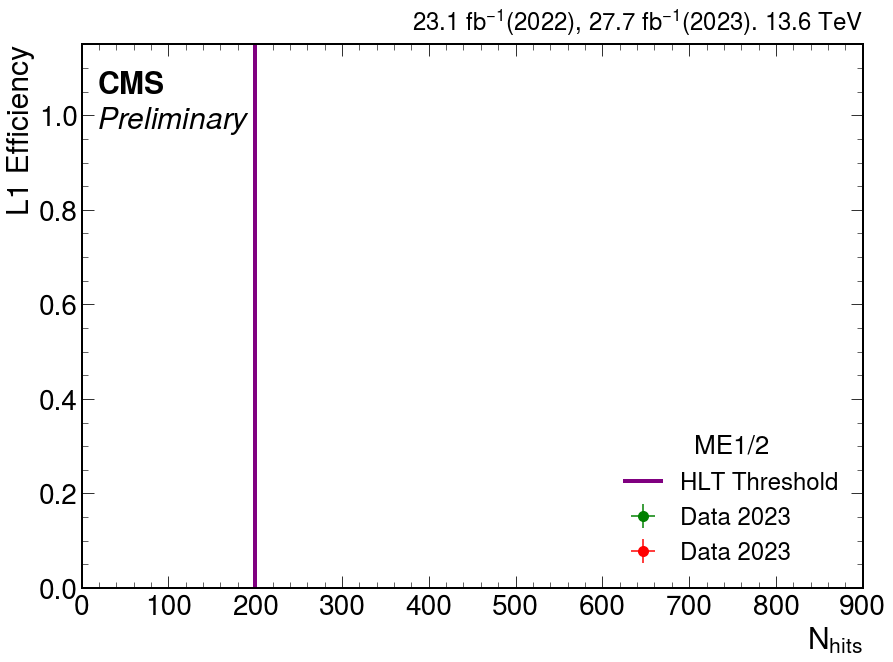

In [78]:
plt.figure(figsize=(14,10))
chamber="ME12"
chamber_with_slash = chamber[:3] + '/' + chamber[3]
bins = bins_ME12
for num, sample in enumerate(['2022', '2023']):
    #if sample=='all':
        #labelName = '2022 + 2023'
    if num==0:
        plt.axvline(chamber_locations[chamber]["HLT_thresh"], color="purple", label="HLT Threshold", linewidth=4)
    else:
        labelName = sample
    num_hist, denom_hist = get_efficiency_hists(oneClusterEvents[sample], chamber, bins)
    
    hist.plotratio(
        ax=plt.gca(),
        num =num_hist.project(bins),
        denom=denom_hist.project(bins),
        error_opts={'marker': '.', 'markersize': 20, 'color':colors[num]},
        unc='clopper-pearson',
        label= "Data " + labelName,
        clear=False,
        xerr=True
        )
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3]
#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=chamber_with_slash)
plt.legend(title=chamber_with_slash, fontsize=24, loc=4)
plt.xlabel("$\mathregular{N_{hits}}$", fontsize=30)
plt.ylabel("L1 Efficiency", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=28)
#hep.cms.label(ax=plt.gca(),data=True, lumi="50.8", fontsize=28, loc=2,COM=13.6)
plt.gca().text(1.0, 1.07, "23.1 $\mathregular{fb^{-1}}$(2022), 27.7 $\mathregular{fb^{-1}}$(2023). 13.6 TeV", transform=plt.gca().transAxes,
        fontsize=24, verticalalignment='top', horizontalalignment='right')
plt.gca().text(0.02, 0.95, r"$\bf{CMS}$"+"\n"+r"$\it{Preliminary}$", transform=plt.gca().transAxes,
       fontsize=30, verticalalignment='top', horizontalalignment='left')
plt.xlim(0,900)
plt.ylim(0, 1.15)
plt.savefig(f"L1_Efficiency_Plots/{chamber}_{myString}.png")

### ME13

In [79]:
bins_ME13 = hist.Bin("cluster_size", "Cluster Size", np.concatenate([np.arange(0, 200, 20), np.arange(200, 1000, 100)]))

77025
78494


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


96646
98465


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


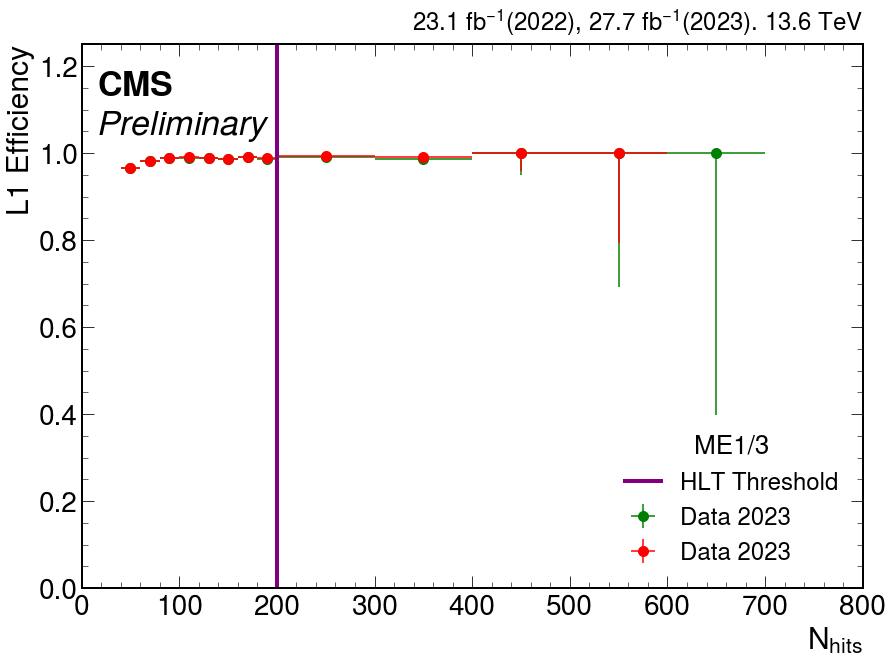

In [80]:
plt.figure(figsize=(14,10))
chamber="ME13"
chamber_with_slash = chamber[:3] + '/' + chamber[3]
bins = bins_ME13
for num, sample in enumerate(['2022', '2023']):
    #if sample=='all':
        #labelName = '2022 + 2023'
    if num==0:
        plt.axvline(chamber_locations[chamber]["HLT_thresh"], color="purple", label="HLT Threshold", linewidth=4)
    else:
        labelName = sample
    num_hist, denom_hist = get_efficiency_hists(oneClusterEvents[sample], chamber, bins)
    
    hist.plotratio(
        ax=plt.gca(),
        num =num_hist.project(bins),
        denom=denom_hist.project(bins),
        error_opts={'marker': '.', 'markersize': 20, 'color':colors[num]},
        unc='clopper-pearson',
        label= "Data " + labelName,
        clear=False,
        xerr=True
        )
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3]
#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=chamber_with_slash)
plt.legend(title=chamber_with_slash, fontsize=24)
plt.xlabel("$\mathregular{N_{hits}}$", fontsize=30)
plt.ylabel("L1 Efficiency", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=28)
#hep.cms.label(ax=plt.gca(),data=True, lumi="50.8", fontsize=28, loc=2,COM=13.6)
plt.gca().text(1.0, 1.07, "23.1 $\mathregular{fb^{-1}}$(2022), 27.7 $\mathregular{fb^{-1}}$(2023). 13.6 TeV", transform=plt.gca().transAxes,
        fontsize=24, verticalalignment='top', horizontalalignment='right')
plt.gca().text(0.02, 0.95, r"$\bf{CMS}$"+"\n"+r"$\it{Preliminary}$", transform=plt.gca().transAxes,
       fontsize=34, verticalalignment='top', horizontalalignment='left')
plt.xlim(0,800)
plt.ylim(0, 1.25)
plt.savefig(f"L1_Efficiency_Plots/{chamber}_{myString}.png")

### ME21

In [81]:
bins_ME21 = hist.Bin("cluster_size", "Cluster Size", np.concatenate([np.arange(0, 500, 100), np.arange(500, 1000, 400)]))

768
444180
1018
457111


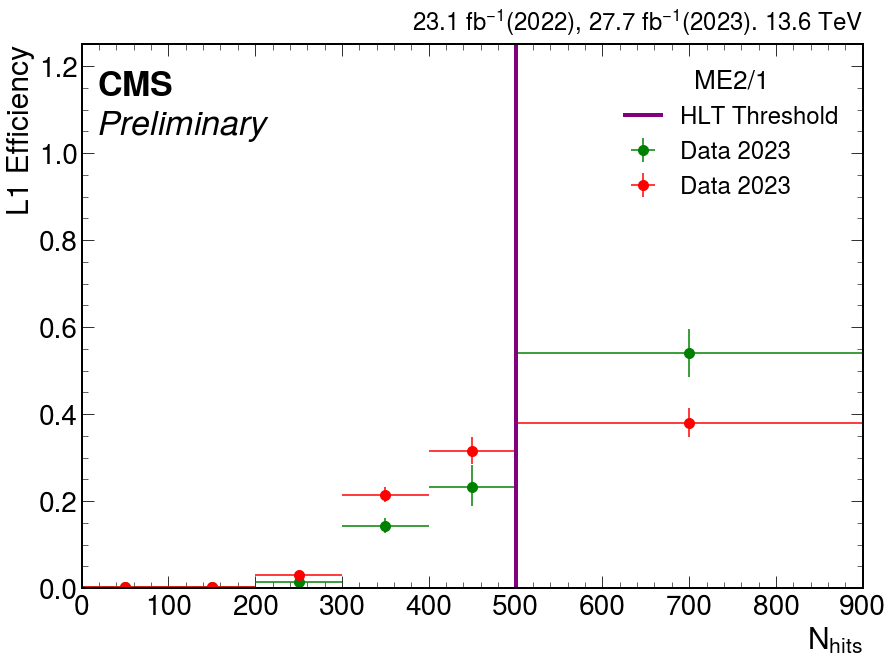

In [82]:
plt.figure(figsize=(14,10))
chamber="ME21"
chamber_with_slash = chamber[:3] + '/' + chamber[3]
bins = bins_ME21
for num, sample in enumerate(['2022', '2023']):
    #if sample=='all':
        #labelName = '2022 + 2023'
    if num==0:
        plt.axvline(chamber_locations[chamber]["HLT_thresh"], color="purple", label="HLT Threshold", linewidth=4)
    else:
        labelName = sample
    num_hist, denom_hist = get_efficiency_hists(oneClusterEvents[sample], chamber, bins)
    
    hist.plotratio(
        ax=plt.gca(),
        num =num_hist.project(bins),
        denom=denom_hist.project(bins),
        error_opts={'marker': '.', 'markersize': 20, 'color':colors[num]},
        unc='clopper-pearson',
        label= "Data " + labelName,
        clear=False,
        xerr=True
        )
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3]
#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=chamber_with_slash)
plt.legend(title=chamber_with_slash, fontsize=24)
plt.xlabel("$\mathregular{N_{hits}}$", fontsize=30)
plt.ylabel("L1 Efficiency", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=28)
#hep.cms.label(ax=plt.gca(),data=True, lumi="50.8", fontsize=28, loc=2,COM=13.6)
plt.gca().text(1.0, 1.07, "23.1 $\mathregular{fb^{-1}}$(2022), 27.7 $\mathregular{fb^{-1}}$(2023). 13.6 TeV", transform=plt.gca().transAxes,
        fontsize=24, verticalalignment='top', horizontalalignment='right')
plt.gca().text(0.02, 0.95, r"$\bf{CMS}$"+"\n"+r"$\it{Preliminary}$", transform=plt.gca().transAxes,
       fontsize=34, verticalalignment='top', horizontalalignment='left')
plt.xlim(0,900)
plt.ylim(0, 1.25)
plt.savefig(f"L1_Efficiency_Plots/{chamber}_{myString}.png")

### ME22

In [83]:
bins_ME22 = hist.Bin("cluster_size", "Cluster Size", np.concatenate([np.arange(0, 200, 50), np.arange(200, 1000, 100)]))

46819
98672


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


58518
129699


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


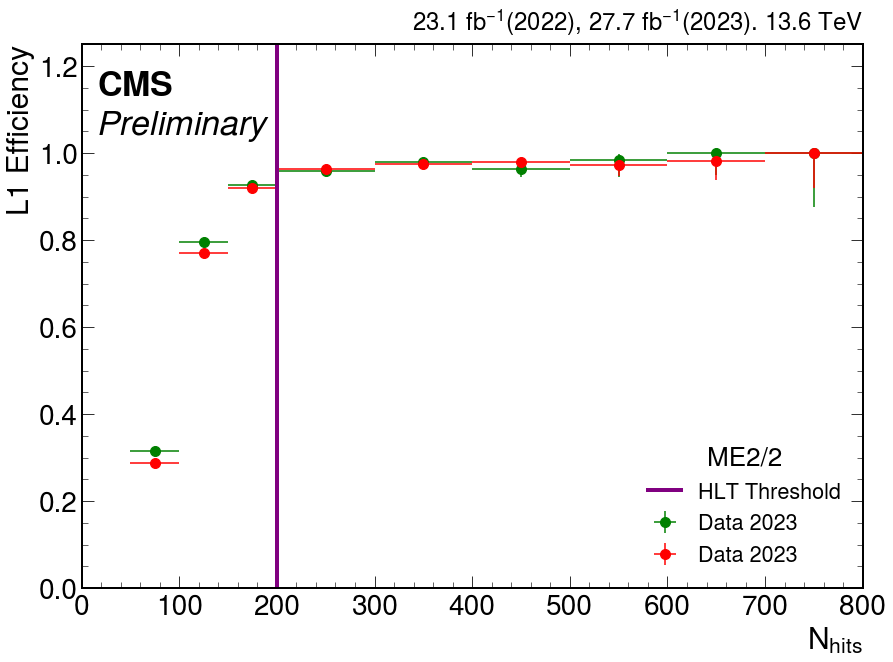

In [84]:
plt.figure(figsize=(14,10))
chamber="ME22"
chamber_with_slash = chamber[:3] + '/' + chamber[3]
bins = bins_ME22
for num, sample in enumerate(['2022', '2023']):
    #if sample=='all':
        #labelName = '2022 + 2023'
    if num==0:
        plt.axvline(chamber_locations[chamber]["HLT_thresh"], color="purple", label="HLT Threshold", linewidth=4)
    else:
        labelName = sample
    num_hist, denom_hist = get_efficiency_hists(oneClusterEvents[sample], chamber, bins)
    
    hist.plotratio(
        ax=plt.gca(),
        num =num_hist.project(bins),
        denom=denom_hist.project(bins),
        error_opts={'marker': '.', 'markersize': 20, 'color':colors[num]},
        unc='clopper-pearson',
        label= "Data " + labelName,
        clear=False,
        xerr=True
        )
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3,1,2]

#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=chamber_with_slash, loc=8)
plt.legend(title=chamber_with_slash)
plt.xlabel("$\mathregular{N_{hits}}$", fontsize=30)
plt.ylabel("L1 Efficiency", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=28)
#hep.cms.label(ax=plt.gca(),data=True, lumi="50.8", fontsize=28, loc=2,COM=13.6)
plt.gca().text(1.0, 1.07, "23.1 $\mathregular{fb^{-1}}$(2022), 27.7 $\mathregular{fb^{-1}}$(2023). 13.6 TeV", transform=plt.gca().transAxes,
        fontsize=24, verticalalignment='top', horizontalalignment='right')
plt.gca().text(0.02, 0.95, r"$\bf{CMS}$"+"\n"+r"$\it{Preliminary}$", transform=plt.gca().transAxes,
       fontsize=34, verticalalignment='top', horizontalalignment='left')
plt.xlim(0,800)
plt.ylim(0, 1.25)
plt.savefig(f"L1_Efficiency_Plots/{chamber}_{myString}.png")

### ME31

In [85]:
bins_ME31 = hist.Bin("cluster_size", "Cluster Size", np.concatenate([np.arange(0, 500, 100), np.arange(500, 1000, 400)]))

In [86]:
chamber_int=0

453
91667
957
108486


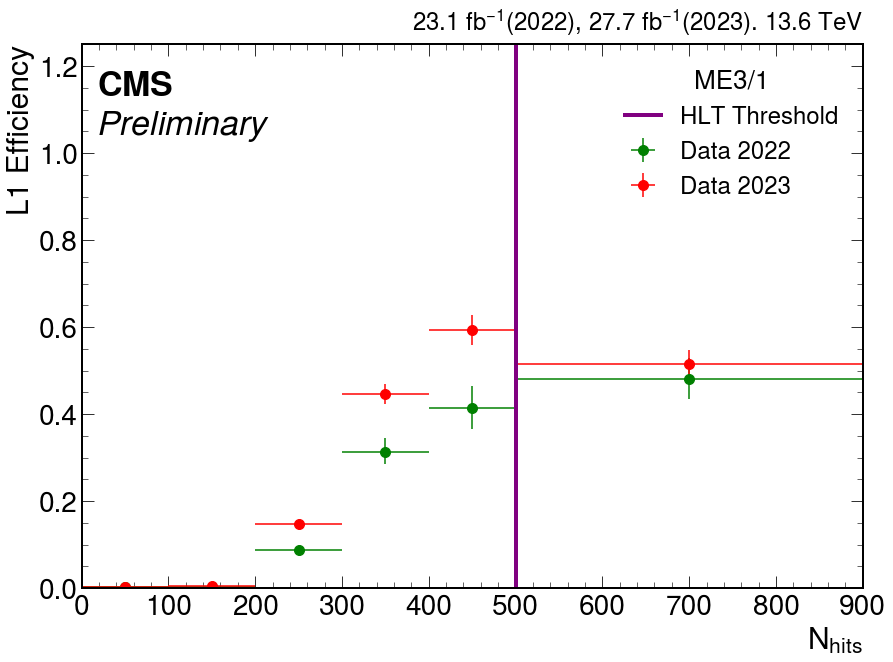

In [88]:
plt.figure(figsize=(14,10))
chamber="ME31"
chamber_with_slash = chamber[:3] + '/' + chamber[3]
bins = bins_ME31
for num, sample in enumerate(['2022', '2023']):
    #if sample=='all':
        #labelName = '2022 + 2023'
    if num==0:
        plt.axvline(chamber_locations[chamber]["HLT_thresh"], color="purple", label="HLT Threshold", linewidth=4)
    
    labelName = sample
    num_hist, denom_hist = get_efficiency_hists(oneClusterEvents[sample], chamber, bins)
    
    hist.plotratio(
        ax=plt.gca(),
        num =num_hist.project(bins),
        denom=denom_hist.project(bins),
        error_opts={'marker': '.', 'markersize': 20, 'color':colors[num]},
        unc='clopper-pearson',
        label= "Data " + labelName,
        clear=False,
        xerr=True
        )
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3]
#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=chamber_with_slash)
plt.legend(title=chamber_with_slash, fontsize=24)
plt.xlabel("$\mathregular{N_{hits}}$", fontsize=30)
plt.ylabel("L1 Efficiency", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=28)
#hep.cms.label(ax=plt.gca(),data=True, lumi="50.8", fontsize=28, loc=2,COM=13.6)
plt.gca().text(1.0, 1.07, "23.1 $\mathregular{fb^{-1}}$(2022), 27.7 $\mathregular{fb^{-1}}$(2023). 13.6 TeV", transform=plt.gca().transAxes,
        fontsize=24, verticalalignment='top', horizontalalignment='right')
plt.gca().text(0.02, 0.95, r"$\bf{CMS}$"+"\n"+r"$\it{Preliminary}$", transform=plt.gca().transAxes,
       fontsize=34, verticalalignment='top', horizontalalignment='left')
plt.xlim(0,900)
plt.ylim(0, 1.25)
plt.savefig(f"L1_Efficiency_Plots/{chamber}_{myString}.png")

### ME32

In [89]:
bins_ME32 = hist.Bin("cluster_size", "Cluster Size", np.concatenate([np.arange(0, 200, 50), np.arange(200, 1000, 100)]))

12066
26142


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


14696
33235


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


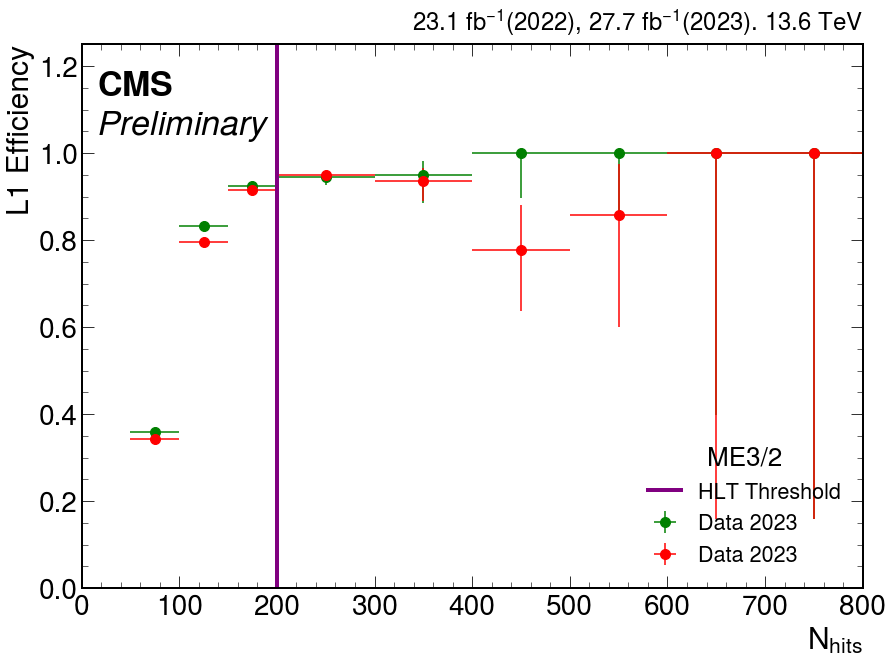

In [90]:
plt.figure(figsize=(14,10))
chamber="ME32"
chamber_with_slash = chamber[:3] + '/' + chamber[3]
bins = bins_ME32
for num, sample in enumerate(['2022', '2023']):
    #if sample=='all':
        #labelName = '2022 + 2023'
    if num==0:
        plt.axvline(chamber_locations[chamber]["HLT_thresh"], color="purple", label="HLT Threshold", linewidth=4)
    else:
        labelName = sample
    num_hist, denom_hist = get_efficiency_hists(oneClusterEvents[sample], chamber, bins)
    
    hist.plotratio(
        ax=plt.gca(),
        num =num_hist.project(bins),
        denom=denom_hist.project(bins),
        error_opts={'marker': '.', 'markersize': 20, 'color':colors[num]},
        unc='clopper-pearson',
        label= "Data " + labelName,
        clear=False,
        xerr=True
        )
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3,1,2]

#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=chamber_with_slash, loc=8)
plt.legend(title=chamber_with_slash)
plt.xlabel("$\mathregular{N_{hits}}$", fontsize=30)
plt.ylabel("L1 Efficiency", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=28)
#hep.cms.label(ax=plt.gca(),data=True, lumi="50.8", fontsize=28, loc=2,COM=13.6)
plt.gca().text(1.0, 1.07, "23.1 $\mathregular{fb^{-1}}$(2022), 27.7 $\mathregular{fb^{-1}}$(2023). 13.6 TeV", transform=plt.gca().transAxes,
        fontsize=24, verticalalignment='top', horizontalalignment='right')
plt.gca().text(0.02, 0.95, r"$\bf{CMS}$"+"\n"+r"$\it{Preliminary}$", transform=plt.gca().transAxes,
       fontsize=34, verticalalignment='top', horizontalalignment='left')
plt.xlim(0,800)
plt.ylim(0, 1.25)
plt.savefig(f"L1_Efficiency_Plots/{chamber}_{myString}.png")

### ME 4/1

In [91]:
bins_ME41 = hist.Bin("cluster_size", "Cluster Size", np.concatenate([np.arange(0, 500, 100), np.arange(500, 1000, 400)]))

332
125493
770
154667


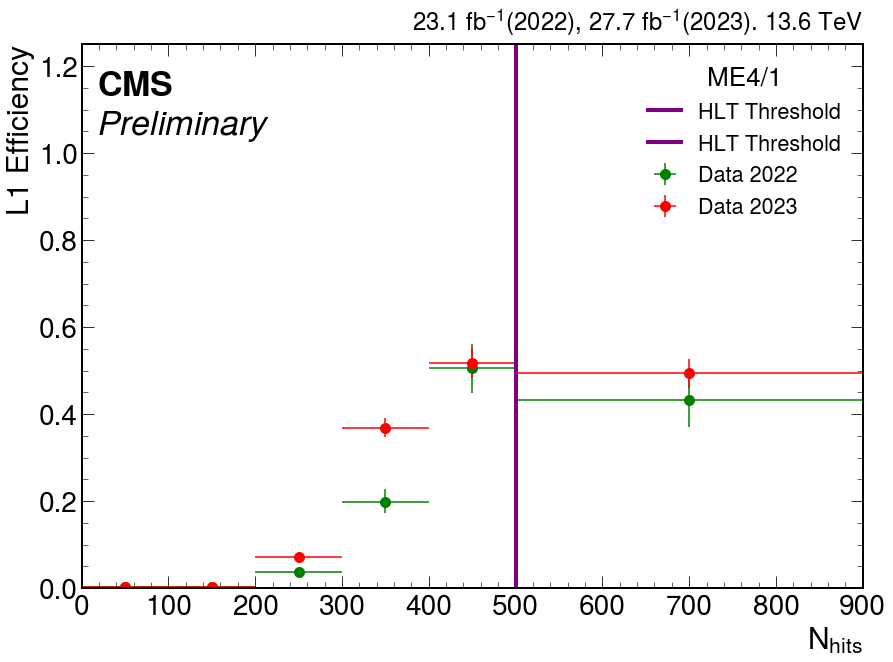

In [93]:
myString = "negEndcap_bothyears_noPhi>3"
plt.figure(figsize=(14,10))
chamber="ME41"
chamber_with_slash = chamber[:3] + '/' + chamber[3]
bins = bins_ME41
for num, sample in enumerate(['2022', '2023']):
    #if sample=='all':
        #labelName = '2022 + 2023'
    if num==0:
        plt.axvline(chamber_locations[chamber]["HLT_thresh"], color="purple", label="HLT Threshold", linewidth=4)
    else:
        labelName = sample
    if num==0:
        plt.axvline(chamber_locations[chamber]["HLT_thresh"], color="purple", label="HLT Threshold", linewidth=4)
    
    labelName = sample
    num_hist, denom_hist = get_efficiency_hists(oneClusterEvents[sample], chamber, bins)
    
    hist.plotratio(
        ax=plt.gca(),
        num =num_hist.project(bins),
        denom=denom_hist.project(bins),
        error_opts={'marker': '.', 'markersize': 20, 'color':colors[num]},
        unc='clopper-pearson',
        label= "Data " + labelName,
        clear=False,
        xerr=True
        )
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3,1,2]

#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=chamber_with_slash, loc=8)
plt.legend(title=chamber_with_slash)
plt.xlabel("$\mathregular{N_{hits}}$", fontsize=30)
plt.ylabel("L1 Efficiency", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=28)
#hep.cms.label(ax=plt.gca(),data=True, lumi="50.8", fontsize=28, loc=2,COM=13.6)
plt.gca().text(1.0, 1.07, "23.1 $\mathregular{fb^{-1}}$(2022), 27.7 $\mathregular{fb^{-1}}$(2023). 13.6 TeV", transform=plt.gca().transAxes,
        fontsize=24, verticalalignment='top', horizontalalignment='right')
plt.gca().text(0.02, 0.95, r"$\bf{CMS}$"+"\n"+r"$\it{Preliminary}$", transform=plt.gca().transAxes,
       fontsize=34, verticalalignment='top', horizontalalignment='left')
plt.xlim(0,900)
plt.ylim(0, 1.25)
plt.savefig(f"L1_Efficiency_Plots/{chamber}_{myString}.png")

### ME4/2

In [94]:
bins_ME42 = hist.Bin("cluster_size", "Cluster Size", np.concatenate([np.arange(0, 200, 50), np.arange(200, 1000, 100)]))

1570
24066


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


1992
30961


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


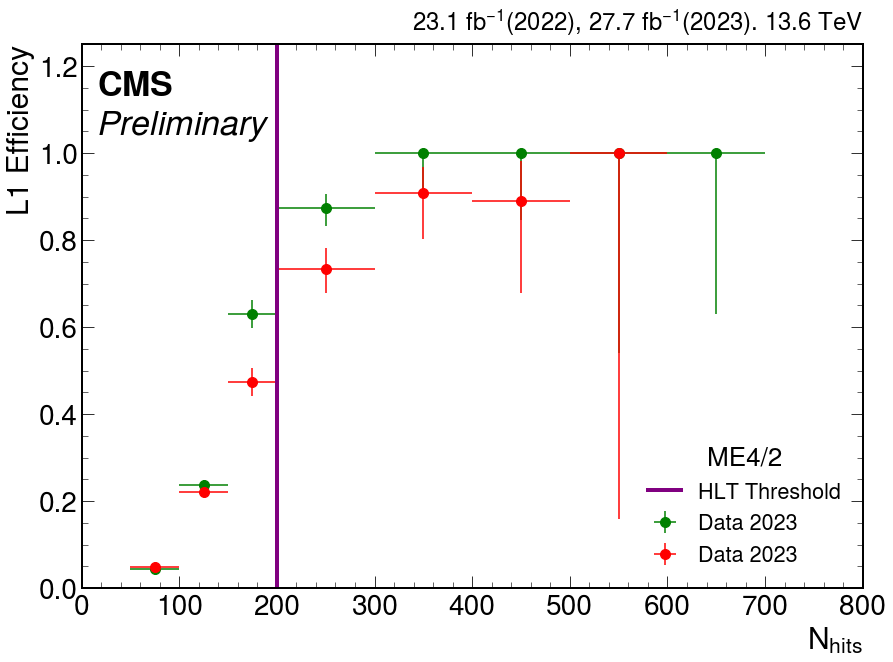

In [95]:
plt.figure(figsize=(14,10))
chamber="ME42"
chamber_with_slash = chamber[:3] + '/' + chamber[3]
bins = bins_ME42
for num, sample in enumerate(['2022', '2023']):
    #if sample=='all':
        #labelName = '2022 + 2023'
    if num==0:
        plt.axvline(chamber_locations[chamber]["HLT_thresh"], color="purple", label="HLT Threshold", linewidth=4)
    else:
        labelName = sample
    num_hist, denom_hist = get_efficiency_hists(oneClusterEvents[sample], chamber, bins)
    
    hist.plotratio(
        ax=plt.gca(),
        num =num_hist.project(bins),
        denom=denom_hist.project(bins),
        error_opts={'marker': '.', 'markersize': 20, 'color':colors[num]},
        unc='clopper-pearson',
        label= "Data " + labelName,
        clear=False,
        xerr=True
        )
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3,1,2]

#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=chamber_with_slash, loc=8)
plt.legend(title=chamber_with_slash)
plt.xlabel("$\mathregular{N_{hits}}$", fontsize=30)
plt.ylabel("L1 Efficiency", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=28)
#hep.cms.label(ax=plt.gca(),data=True, lumi="50.8", fontsize=28, loc=2,COM=13.6)
plt.gca().text(1.0, 1.07, "23.1 $\mathregular{fb^{-1}}$(2022), 27.7 $\mathregular{fb^{-1}}$(2023). 13.6 TeV", transform=plt.gca().transAxes,
        fontsize=24, verticalalignment='top', horizontalalignment='right')
plt.gca().text(0.02, 0.95, r"$\bf{CMS}$"+"\n"+r"$\it{Preliminary}$", transform=plt.gca().transAxes,
       fontsize=34, verticalalignment='top', horizontalalignment='left')
plt.xlim(0,800)
plt.ylim(0, 1.25)
plt.savefig(f"L1_Efficiency_Plots/{chamber}_{myString}.png")

In [ ]:
plt.figure(figsize=(14,10))
num_hist, denom_hist = get_efficiency_hists(oneClusterEvents['all'], "ME41", bins_ME31, endcap=0)
hist.plot1d(denom_hist)
plt.title("Cluster Size Distribution for ME4/1Noise Clusters, abs(phi)>3", fontsize=24)

### Separate Inner Ring Chambers by Endcap

In [ ]:
endcap_str = "by_endcap_allData"

In [ ]:
plt.figure(figsize=(14,10))
chamber="ME21"
chamber_with_slash = chamber[:3] + '/' + chamber[3]
bins = bins_ME21
for num, sample in enumerate(['all']):
    if num==0:
        plt.axvline(chamber_locations[chamber]["HLT_thresh"], color="purple", label="HLT Threshold", linewidth=4)
    for x in range(2):
        num_hist, denom_hist = get_efficiency_hists(oneClusterEvents[sample], chamber, bins, endcap=x)
        if x==0:
            label="negative endcap"
        if x==1:
            label="positive endcap"
        hist.plotratio(
            ax=plt.gca(),
            num =num_hist.project(bins),
            denom=denom_hist.project(bins),
            error_opts={'marker': '.', 'markersize': 20, 'color':colors[x]},
            unc='clopper-pearson',
            label= label,
            clear=False,
            xerr=True
            )
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3]
#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=chamber_with_slash)
plt.legend(title=chamber_with_slash, fontsize=24)
plt.xlabel("$\mathregular{N_{hits}}$", fontsize=30)
plt.ylabel("L1 Efficiency", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=28)
#hep.cms.label(ax=plt.gca(),data=True, lumi="50.8", fontsize=28, loc=2,COM=13.6)
plt.gca().text(1.0, 1.07, "23.1 $\mathregular{fb^{-1}}$(2022), 27.7 $\mathregular{fb^{-1}}$(2023). 13.6 TeV", transform=plt.gca().transAxes,
        fontsize=24, verticalalignment='top', horizontalalignment='right')
plt.gca().text(0.02, 0.95, r"$\bf{CMS}$"+"\n"+r"$\it{Preliminary}$", transform=plt.gca().transAxes,
       fontsize=34, verticalalignment='top', horizontalalignment='left')
plt.xlim(0,900)
plt.ylim(0, 1.25)
plt.savefig(f"L1_Efficiency_Plots/{chamber}_{endcap_str}.png")

In [ ]:
plt.figure(figsize=(14,10))
chamber="ME31"
chamber_with_slash = chamber[:3] + '/' + chamber[3]
bins = bins_ME31
for num, sample in enumerate(['all']):
    if num==0:
        plt.axvline(chamber_locations[chamber]["HLT_thresh"], color="purple", label="HLT Threshold", linewidth=4)
    for x in range(2):
        num_hist, denom_hist = get_efficiency_hists(oneClusterEvents[sample], chamber, bins, endcap=x)
        if x==0:
            label="negative endcap"
        if x==1:
            label="positive endcap"
        hist.plotratio(
            ax=plt.gca(),
            num =num_hist.project(bins),
            denom=denom_hist.project(bins),
            error_opts={'marker': '.', 'markersize': 20, 'color':colors[x]},
            unc='clopper-pearson',
            label= label,
            clear=False,
            xerr=True
            )
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3]
#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=chamber_with_slash)
plt.legend(title=chamber_with_slash, fontsize=24)
plt.xlabel("$\mathregular{N_{hits}}$", fontsize=30)
plt.ylabel("L1 Efficiency", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=28)
#hep.cms.label(ax=plt.gca(),data=True, lumi="50.8", fontsize=28, loc=2,COM=13.6)
plt.gca().text(1.0, 1.07, "23.1 $\mathregular{fb^{-1}}$(2022), 27.7 $\mathregular{fb^{-1}}$(2023). 13.6 TeV", transform=plt.gca().transAxes,
        fontsize=24, verticalalignment='top', horizontalalignment='right')
plt.gca().text(0.02, 0.95, r"$\bf{CMS}$"+"\n"+r"$\it{Preliminary}$", transform=plt.gca().transAxes,
       fontsize=34, verticalalignment='top', horizontalalignment='left')
plt.xlim(0,900)
plt.ylim(0, 1.25)
plt.savefig(f"L1_Efficiency_Plots/{chamber}_{endcap_str}.png")

In [ ]:
plt.figure(figsize=(14,10))
chamber="ME41"
chamber_with_slash = chamber[:3] + '/' + chamber[3]
bins = bins_ME41
for num, sample in enumerate(['all']):
    if num==0:
        plt.axvline(chamber_locations[chamber]["HLT_thresh"], color="purple", label="HLT Threshold", linewidth=4)
    for x in range(2):
        num_hist, denom_hist = get_efficiency_hists(oneClusterEvents[sample], chamber, bins, endcap=x)
        if x==0:
            label="negative endcap"
        if x==1:
            label="positive endcap"
        hist.plotratio(
            ax=plt.gca(),
            num =num_hist.project(bins),
            denom=denom_hist.project(bins),
            error_opts={'marker': '.', 'markersize': 20, 'color':colors[x]},
            unc='clopper-pearson',
            label= label,
            clear=False,
            xerr=True
            )
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3]
#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=chamber_with_slash)
plt.legend(title=chamber_with_slash, fontsize=24)
plt.xlabel("$\mathregular{N_{hits}}$", fontsize=30)
plt.ylabel("L1 Efficiency", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=28)
#hep.cms.label(ax=plt.gca(),data=True, lumi="50.8", fontsize=28, loc=2,COM=13.6)
plt.gca().text(1.0, 1.07, "23.1 $\mathregular{fb^{-1}}$(2022), 27.7 $\mathregular{fb^{-1}}$(2023). 13.6 TeV", transform=plt.gca().transAxes,
        fontsize=24, verticalalignment='top', horizontalalignment='right')
plt.gca().text(0.02, 0.95, r"$\bf{CMS}$"+"\n"+r"$\it{Preliminary}$", transform=plt.gca().transAxes,
       fontsize=34, verticalalignment='top', horizontalalignment='left')
plt.xlim(0,900)
plt.ylim(0, 1.25)
plt.savefig(f"L1_Efficiency_Plots/{chamber}_{endcap_str}.png")

In [ ]:
#explore events with clusters in ME4/1 with >500 cscRechits
event_mask = np.logical_and(compute_chamber_mask(oneClusterEvents['all'], "ME41", 41, 0.9, endcap=0), ak.flatten(oneClusterEvents['all'].cscRechitClusterSize)>=500)
weird_data = ak.mask(oneClusterEvents['all'], event_mask)
weird_data = weird_data[~ak.is_none(weird_data)]
weird_data.evtNum

In [ ]:
with open('ME41_weird_events.npy', 'wb') as f:
    np.save(f, np.array(weird_data.evtNum))


In [ ]:
list(chamber_locations.keys())

In [ ]:
#For all chambers
events_list_2022 = []
for chamber in list(chamber_locations.keys()):
    event_mask = compute_chamber_mask(oneClusterEvents['2022'], chamber, 41, 0.9)
    my_data = ak.mask(oneClusterEvents['2022'], event_mask)
    my_data = my_data[~ak.is_none(my_data)]
    events_list_2022.append(np.array(my_data.evtNum))
    
with open('all_chambers_events_2022.npy', 'wb') as f:
    np.save(f, np.concatenate(events_list_2022))
    
events_list_2023 = []
for chamber in list(chamber_locations.keys()):
    event_mask = compute_chamber_mask(oneClusterEvents['2023'], chamber, 41, 0.9)
    my_data = ak.mask(oneClusterEvents['2023'], event_mask)
    my_data = my_data[~ak.is_none(my_data)]
    events_list_2023.append(np.array(my_data.evtNum))
    
with open('all_chambers_events_2023.npy', 'wb') as f:
    np.save(f, np.concatenate(events_list_2023))

In [60]:
sample

'all'

In [65]:
num = 0
colors= ["black"]

In [81]:
bins_ME41.centers()

array([ 50., 150., 250., 350., 450., 700.])

### Extracting Efficiencies to store in ROOT Files

216
1009


(0.0, 900.0)

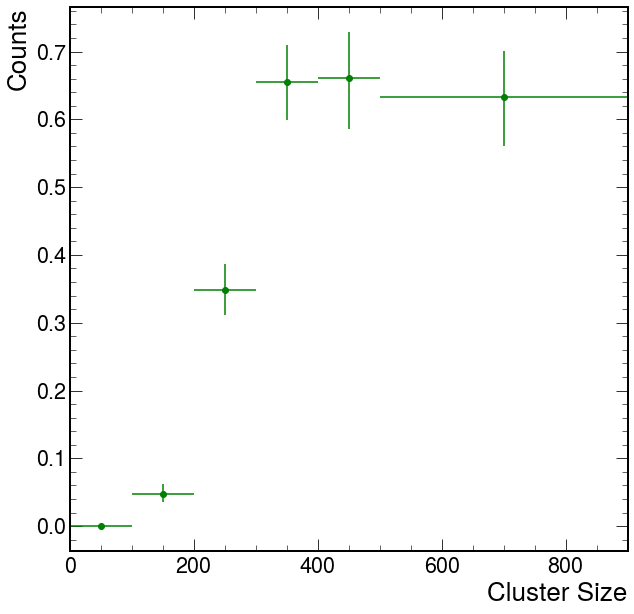

In [154]:
labelName = '2022 + 2023'
chamber="ME31"
num=0
chamber_with_slash = chamber[:3] + '/' + chamber[3]
bins = bins_ME31
num_hist, denom_hist = get_efficiency_hists(oneClusterEvents[sample], chamber, bins)

efficiency_plot = hist.plotratio(
    ax=plt.gca(),
    num =num_hist.project(bins),
    denom=denom_hist.project(bins),
    error_opts={'marker': '.', 'markersize': 12, 'color':colors[num]},
    unc='clopper-pearson',
    label= "Data " + labelName,
    clear=False,
    xerr=True
    )
plt.xlim(0,900)

In [89]:
def dump_chamber_efficiency_plot(chamber, num_hist, denom_hist, bins):  
    bin_centers = bins.centers()
    efficiencies, xerrs, yerrs_low, yerrs_high = [],[],[],[]
    #print(list(denom_hist.project(bins).values().values()))[0]
    num_values = list(num_hist.project(bins).values().values())[0]
    denom_values = list(denom_hist.project(bins).values().values())[0]
    for bin_idx in range(len(bin_centers)):
        if bin_idx==0:
            xerrs.append((bin_centers[bin_idx+1]-bin_centers[bin_idx])/2)
        #elif bin_idx==len(bin_centers)-1:
        #    xerrs.append((bin_centers[bin_idx]-bin_centers[bin_idx-1])/2)
        #elif (bin_centers[bin_idx+1]-bin_centers[bin_idx])/2 > (bin_centers[bin_idx]-bin_centers[bin_idx-1])/2:
        #    xerrs.append((bin_centers[bin_idx]-bin_centers[bin_idx-1])/2)
        #elif (bin_centers[bin_idx+1]-bin_centers[bin_idx])/2  (bin_centers[bin_idx]-bin_centers[bin_idx-1])/2:
        #    xerrs.append((bin_centers[bin_idx]-bin_centers[bin_idx-1])/2)
        else:
            #xerrs.append(((bin_centers[bin_idx+1]-bin_centers[bin_idx])/2 + (bin_centers[bin_idx]-bin_centers[bin_idx-1])/2)/2)
            #print("here")
            xerrs.append(bin_centers[bin_idx]-bin_centers[bin_idx-1]-xerrs[len(xerrs)-1])
        #efficiencies.append(float(num_values[bin_idx])/denom_values[bin_idx])
        #code to recompute errors bars
        eff = ROOT.TEfficiency()
        eff.SetStatisticOption(ROOT.TEfficiency.kFCP)  # Use Clopper-Pearson
        passed = int(num_values[bin_idx])
        total = int(denom_values[bin_idx])
        if total > 0:
            eff.SetTotalEvents(1, total)
            eff.SetPassedEvents(1, passed)
            efficiencies.append(eff.GetEfficiency(1))
            yerrs_low.append(eff.GetEfficiencyErrorLow(1))
            yerrs_high.append(eff.GetEfficiencyErrorUp(1))
        else:
            efficiencies.append(0)
            yerrs_low.append(0)
            yerrs_high.append(0)

    x_values = np.array(bin_centers, dtype='float64')
    y_values = np.array(efficiencies, dtype='float64')
    x_errors = np.array(xerrs)  # Using half the bin width as the error in x
    y_errors_low = np.array(yerrs_low, dtype='float64')
    y_errors_high = np.array(yerrs_high, dtype='float64')
    n_bins = len(bin_centers)
    # Create a TGraphAsymmErrors object
    root_graph = ROOT.TGraphAsymmErrors(n_bins, x_values, y_values, x_errors, x_errors, y_errors_low, y_errors_high)
    root_graph.SetTitle(f"{chamber};Cluster Size;L1 Efficiency")
    return root_graph

In [143]:
def dump_chamber_efficiency_plot(chamber, num_hist, denom_hist, bins):  
    bin_centers = bins.centers()
    efficiencies, xerrs, yerrs_low, yerrs_high = [],[],[],[]
    #print(list(denom_hist.project(bins).values().values()))[0]
    num_values = list(num_hist.project(bins).values().values())[0]
    denom_values = list(denom_hist.project(bins).values().values())[0]
    for bin_idx in range(len(bin_centers)):
        if bin_idx==0:
            xerrs.append((bin_centers[bin_idx+1]-bin_centers[bin_idx])/2)
        #elif bin_idx==len(bin_centers)-1:
        #    xerrs.append((bin_centers[bin_idx]-bin_centers[bin_idx-1])/2)
        #elif (bin_centers[bin_idx+1]-bin_centers[bin_idx])/2 > (bin_centers[bin_idx]-bin_centers[bin_idx-1])/2:
        #    xerrs.append((bin_centers[bin_idx]-bin_centers[bin_idx-1])/2)
        #elif (bin_centers[bin_idx+1]-bin_centers[bin_idx])/2  (bin_centers[bin_idx]-bin_centers[bin_idx-1])/2:
        #    xerrs.append((bin_centers[bin_idx]-bin_centers[bin_idx-1])/2)
        else:
            #xerrs.append(((bin_centers[bin_idx+1]-bin_centers[bin_idx])/2 + (bin_centers[bin_idx]-bin_centers[bin_idx-1])/2)/2)
            #print("here")
            xerrs.append(bin_centers[bin_idx]-bin_centers[bin_idx-1]-xerrs[len(xerrs)-1])
        #efficiencies.append(float(num_values[bin_idx])/denom_values[bin_idx])
        #code to recompute errors bars
        eff = ROOT.TEfficiency()
        eff.SetStatisticOption(ROOT.TEfficiency.kFCP)  # Use Clopper-Pearson
        passed = int(num_values[bin_idx])
        total = int(denom_values[bin_idx])
        if total > 0:
            eff.SetTotalEvents(1, total)
            eff.SetPassedEvents(1, passed)
            efficiencies.append(eff.GetEfficiency(1))
            yerrs_low.append(eff.GetEfficiencyErrorLow(1))
            yerrs_high.append(eff.GetEfficiencyErrorUp(1))
        else:
            efficiencies.append(0)
            yerrs_low.append(0)
            yerrs_high.append(0)

    x_values = np.array(bin_centers, dtype='float64')
    y_values = np.array(efficiencies, dtype='float64')
    x_errors = np.array(xerrs)  # Using half the bin width as the error in x
    y_errors_low = np.array(yerrs_low, dtype='float64')
    y_errors_high = np.array(yerrs_high, dtype='float64')
    n_bins = len(bin_centers)
    # Create a TGraphAsymmErrors object
    root_graph = ROOT.TGraphAsymmErrors(n_bins, x_values, y_values, x_errors, x_errors, y_errors_low, y_errors_high)
    root_graph.SetTitle(f"{chamber};Cluster Size;L1 Efficiency")
    return root_graph

In [90]:
chamber_bins = [bins_ME11, bins_ME12, bins_ME13, bins_ME21, bins_ME22, bins_ME31, bins_ME32, bins_ME41, bins_ME42]

In [148]:
def get_efficiency_hists_ROOT(data, chamber, bins, endcap=None):
    total_mask = compute_chamber_mask(data, chamber, chamber_int, 0.9, endcap)
    
    #COMMENT OUT WHEN NOT DOING NOISE MASK INVERSION
    #total_mask = np.logical_and(total_mask, noisy_cluster_events(data))
    
    denom = ak.mask(ak.flatten(data.cscRechitClusterSize), total_mask)
    num = ak.mask(denom, ak.mask(np.logical_or(data.L1_SingleMuShower_Nominal, data.L1_SingleMuShower_Tight),total_mask))
    denom = denom[~ak.is_none(denom)]
    num = num[~ak.is_none(num)]
    
    denom = ak.to_numpy(denom)
    num = ak.to_numpy(num)
    
    print(len(num))
    print(len(denom))
    inner_bins = np.concatenate([np.arange(0, 500, 100), np.arange(500, 1000, 400)])
    outer_bins = np.concatenate([np.arange(0, 200, 50), np.arange(200, 1000, 100)])
    
    
    if chamber[-1:]=='1':
        bins = inner_bins
    else:
        bins = outer_bins
        
    bins_arr = [binEdge for binEdge in bins]
    
    num_hist = ROOT.TH1F("num", "num", len(bins_arr)-1, array('f', bins_arr))
    denom_hist = ROOT.TH1F("denom", "denom", len(bins_arr)-1, array('f', bins_arr))
    
    for val in num:
        num_hist.Fill(val)
    for val in denom:
        denom_hist.Fill(val)

    return num_hist, denom_hist

In [149]:
from array import array
chamber_int = 0
sample = 'all'
output_file = "L1_efficiencies_2022_2023_082324-TEff.root"
root_file = ROOT.TFile(output_file, "RECREATE")
root_plots = []
for chamber_idx, chamber in enumerate(chambers):
    if chamber in ["ME11", "ME12"]:
        continue
    print(chamber)
    bins = chamber_bins[chamber_idx]
    num_hist, denom_hist = get_efficiency_hists_ROOT(oneClusterEvents[sample], chamber, bins)
    #print(type(num_hist))
    eff = ROOT.TEfficiency(num_hist, denom_hist)
    eff.SetStatisticOption(ROOT.TEfficiency.kFCP) 
    
    #current_plot = dump_chamber_efficiency_plot(chamber, num_hist, denom_hist, bins)
    eff.SetTitle(f"{chamber};Cluster Size;L1 Efficiency")
    eff.Write(chamber)
    
root_file.Close()

ME13
92831
93753
ME21
131
1311
ME22
54075
91407
ME31
216
1009
ME32
13736
20170
ME41
146
678
ME42
459
568


Warning in <TFile::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: denom (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: denom (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: denom (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: denom (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: denom (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: denom (Potential memory leak).


In [150]:
chamber_int = 0
sample = 'all'
output_file = "L1_efficiencies_2022_2023_081924_checkME1.root"
root_file = ROOT.TFile(output_file, "RECREATE")
root_plots = []
for chamber_idx, chamber in enumerate(chambers):
    print(chamber)
    bins = chamber_bins[chamber_idx]
    num_hist, denom_hist = get_efficiency_hists(oneClusterEvents[sample], chamber, bins)
    current_plot = dump_chamber_efficiency_plot(chamber, num_hist, denom_hist, bins)
    current_plot.Write(chamber)
root_file.Close()

ME11
0
0
ME12
0
0
ME13
92831
93753
ME21
131
1311
ME22
54075
91407
ME31
216
1009
ME32
13736
20170
ME41
146
678
ME42
459
568


Warning in <TFile::Append>: Replacing existing TH1: h_passed (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_total (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_passed (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_total (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_passed (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_total (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_passed (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_total (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_passed (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_total (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_passed (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_total

In [61]:
efficiencies, xerrs, yerrs_low, yerrs_high

NameError: name 'efficiencies' is not defined

### Debugging 2023C L1 Inefficiencies

In [ ]:
sample="2023C"
runNum_arr = np.array(oneClusterEvents[sample].runNum)
unique_values, counts = np.unique(runNum_arr, return_counts=True)
runCount_dict = {}
for value, count in zip(unique_values, counts):
    print(f"{value} occurs {count} times")
    runCount_dict[value] = count
runList = list(runCount_dict.keys())

In [ ]:
#break data into sections of at least 3000 events and determine ME22 efficiency
num_ME22_events = {}
for run in runList:
    chamber = "ME41"
    maskZ = np.logical_and(abs(ak.flatten(oneClusterEvents[sample].cscRechitClusterZ))>chamber_locations[chamber]["minZ"], abs(ak.flatten(oneClusterEvents[sample].cscRechitClusterZ))<chamber_locations[chamber]["maxZ"])
    maskR = ak.flatten(np.logical_and((np.sqrt(oneClusterEvents[sample].cscRechitClusterX**2+oneClusterEvents[sample].cscRechitClusterY**2))>chamber_locations[chamber]["MinR"], (np.sqrt(oneClusterEvents[sample].cscRechitClusterX**2+oneClusterEvents[sample].cscRechitClusterY**2))<chamber_locations[chamber]["MaxR"]))
    total_mask = np.logical_and(np.logical_and(np.logical_and(maskZ, maskR), ak.flatten(oneClusterEvents[sample]["cscRechitClusterNStation10"]==1)), oneClusterEvents[sample]["runNum"]==run)
    denom = ak.mask(ak.flatten(oneClusterEvents[sample].cscRechitClusterSize), total_mask)
    denom = denom[~ak.is_none(denom)]
    num_ME22_events[run] =  ak.count(denom)
num_ME22_events 
        

In [ ]:
#group runs together such that there is at least 500 L1 fires per set
run_groupings = []
num_events = []
processed_runs = []
event_thresh = 1000
for runIdx, (run, count) in enumerate(num_ME22_events.items()):
    event_tally = 0
    current_grouping = []
    if run in processed_runs: continue;
    for runIdx2 in range(runIdx, len(runList)):
        event_tally+=num_ME22_events[runList[runIdx2]]
        current_grouping.append(runList[runIdx2])
        processed_runs.append(runList[runIdx2])
        if event_tally > event_thresh:
            run_groupings.append(current_grouping)
            num_events.append(event_tally)
            break
#run_groupings, num_events

In [ ]:
len(num_events)

In [ ]:
plt.style.use(hep.style.CMS) 
import matplotlib
num_rows = 4
num_cols = 7
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 8 * num_rows))

#sample = "2023D"
bins = bins_rechits_lowEta_lowNStation10

counter = 0
for i in range(num_rows):
    for j in range(num_cols):
        run_grouping = run_groupings[counter]
        chamber = 'ME41'
        maskZ = np.logical_and(abs(ak.flatten(oneClusterEvents[sample].cscRechitClusterZ))>chamber_locations[chamber]["minZ"], abs(ak.flatten(oneClusterEvents[sample].cscRechitClusterZ))<chamber_locations[chamber]["maxZ"])
        maskR = ak.flatten(np.logical_and((np.sqrt(oneClusterEvents[sample].cscRechitClusterX**2+oneClusterEvents[sample].cscRechitClusterY**2))>chamber_locations[chamber]["MinR"], (np.sqrt(oneClusterEvents[sample].cscRechitClusterX**2+oneClusterEvents[sample].cscRechitClusterY**2))<chamber_locations[chamber]["MaxR"]))
        total_mask = np.logical_and(np.logical_and(maskZ, maskR), ak.flatten(oneClusterEvents[sample]["cscRechitClusterNStation10"]==1))
        total_mask = np.logical_and(total_mask, oneClusterEvents[sample]["runNum"]>=run_grouping[0])
        total_mask = np.logical_and(total_mask, oneClusterEvents[sample]["runNum"]<=run_grouping[len(run_grouping)-1])
        '''
        run_masks = []
        for run in run_grouping:
            run_masks.append(oneClusterEvents[sample]["runNum"]==run)
        run_mask = np.logical_or.reduce(run_masks)
        '''
        #total_mask = np.logical_and(total_mask, run_mask)

        denom = ak.mask(ak.flatten(oneClusterEvents[sample].cscRechitClusterSize), total_mask)

        num = ak.mask(denom, ak.mask(np.logical_or(oneClusterEvents[sample].L1_SingleMuShower_Nominal, oneClusterEvents[sample].L1_SingleMuShower_Tight),total_mask))
        denom = denom[~ak.is_none(denom)]
        num = num[~ak.is_none(num)]
        counter+=1
        axes[i,j].set_title(f"{run_grouping[0]} - {run_grouping[len(run_grouping)-1]}", fontsize=30)
        axes[i,j].axvline(chamber_locations[chamber]["HLT_thresh"], color="black", label="HLT Threshold")
        if ak.count(denom)==0: 
            axes[i][j].set_xlabel("Cluster Size", fontsize=20)
            axes[i,j].set_ylabel("L1 Efficiency", fontsize=20)
            axes[i,j].set_xlim(0,900)
            continue
        num_hist = hist.Hist("Counts", rechits_axis, bins)
        arr_to_fill = num
        num_hist.fill(sample = f"{ak.count(arr_to_fill)} entries", cluster_size=arr_to_fill)

        denom_hist = hist.Hist("Counts", rechits_axis, bins)
        arr_to_fill = denom
        denom_hist.fill(sample = f"{ak.count(arr_to_fill)} entries", cluster_size=arr_to_fill)

        hist.plotratio(
                    ax=axes[i,j],
                    num =num_hist.project(bins),
                    denom=denom_hist.project(bins),
                    error_opts={'marker': '.'},
                    unc='clopper-pearson',
                    label= "L1 Efficiency",
                    clear=False
                )
        '''
        hist.plotratio(
                    ax=axes[2],
                    num  =rechits_hist_HLTMedium.project(bins_rechits),
                    denom=rechits_hist.project(bins_rechits),
                    error_opts={'marker': '.'},
                    unc='clopper-pearson',
                    label= "Medium",
                    clear=False
                )

        hist.plotratio(
                    ax=axes[2],
                    num  =rechits_hist_HLTTight.project(bins_rechits),
                    denom=rechits_hist.project(bins_rechits),
                    error_opts={'marker': '.'},
                    unc='clopper-pearson',
                    label= "Tight",
                    clear=False
                )
        '''
        axes[i,j].set_ylim(0,1)
        axes[i,j].legend()
        #axes[i,j].set_title(chamber, fontsize=24)
        axes[i][j].set_xlabel("Cluster Size", fontsize=20)
        axes[i,j].set_ylabel("L1 Efficiency", fontsize=20)
fig.suptitle("L1 Efficiencies in ME22 for 2023C - by run #", size=50)
plt.tight_layout()
plt.savefig("L1_2023C_ME41_Run_fix.png")

### Other chambers

In [ ]:
#break data into sections of at least 3000 events and determine ME22 efficiency
num_ME22_events = {}
for run in runList:
    chamber = "ME13"
    maskZ = np.logical_and(abs(ak.flatten(oneClusterEvents[sample].cscRechitClusterZ))>chamber_locations[chamber]["minZ"], abs(ak.flatten(oneClusterEvents[sample].cscRechitClusterZ))<chamber_locations[chamber]["maxZ"])
    maskR = ak.flatten(np.logical_and((np.sqrt(oneClusterEvents[sample].cscRechitClusterX**2+oneClusterEvents[sample].cscRechitClusterY**2))>chamber_locations[chamber]["MinR"], (np.sqrt(oneClusterEvents[sample].cscRechitClusterX**2+oneClusterEvents[sample].cscRechitClusterY**2))<chamber_locations[chamber]["MaxR"]))
    total_mask = np.logical_and(np.logical_and(np.logical_and(maskZ, maskR), ak.flatten(oneClusterEvents[sample]["cscRechitClusterNStation10"]==1)), oneClusterEvents[sample]["runNum"]==run)
    denom = ak.mask(ak.flatten(oneClusterEvents[sample].cscRechitClusterSize), total_mask)
    denom = denom[~ak.is_none(denom)]
    num_ME22_events[run] =  ak.count(denom)
num_ME22_events 
        

In [ ]:
#group runs together such that there is at least 500 L1 fires per set
run_groupings = []
num_events = []
processed_runs = []
event_thresh = 1000
for runIdx, (run, count) in enumerate(num_ME22_events.items()):
    event_tally = 0
    current_grouping = []
    if run in processed_runs: continue;
    for runIdx2 in range(runIdx, len(runList)):
        event_tally+=num_ME22_events[runList[runIdx2]]
        current_grouping.append(runList[runIdx2])
        processed_runs.append(runList[runIdx2])
        if event_tally > event_thresh:
            run_groupings.append(current_grouping)
            num_events.append(event_tally)
            break
#run_groupings, num_events

In [ ]:
len(num_events)

In [ ]:
plt.style.use(hep.style.CMS) 
import matplotlib
num_rows = 4
num_cols = 6
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 8 * num_rows))
fig.suptitle(sample + " L1 Efficiencies from HLT_IsoMuon24 Control Sample")
#sample = "2023D"
bins = bins_rechits_lowEta_lowNStation10

counter = 0
for i in range(num_rows):
    for j in range(num_cols):
        run_grouping = run_groupings[counter]
        chamber = 'ME13'
        maskZ = np.logical_and(abs(ak.flatten(oneClusterEvents[sample].cscRechitClusterZ))>chamber_locations[chamber]["minZ"], abs(ak.flatten(oneClusterEvents[sample].cscRechitClusterZ))<chamber_locations[chamber]["maxZ"])
        maskR = ak.flatten(np.logical_and((np.sqrt(oneClusterEvents[sample].cscRechitClusterX**2+oneClusterEvents[sample].cscRechitClusterY**2))>chamber_locations[chamber]["MinR"], (np.sqrt(oneClusterEvents[sample].cscRechitClusterX**2+oneClusterEvents[sample].cscRechitClusterY**2))<chamber_locations[chamber]["MaxR"]))
        total_mask = np.logical_and(np.logical_and(maskZ, maskR), ak.flatten(oneClusterEvents[sample]["cscRechitClusterNStation10"]==1))
        total_mask = np.logical_and(total_mask, oneClusterEvents[sample]["runNum"]>=run_grouping[0])
        total_mask = np.logical_and(total_mask, oneClusterEvents[sample]["runNum"]<=run_grouping[len(run_grouping)-1])
        '''
        run_masks = []
        for run in run_grouping:
            run_masks.append(oneClusterEvents[sample]["runNum"]==run)
        run_mask = np.logical_or.reduce(run_masks)
        '''
        #total_mask = np.logical_and(total_mask, run_mask)

        denom = ak.mask(ak.flatten(oneClusterEvents[sample].cscRechitClusterSize), total_mask)

        num = ak.mask(denom, ak.mask(np.logical_or(oneClusterEvents[sample].L1_SingleMuShower_Nominal, oneClusterEvents[sample].L1_SingleMuShower_Tight),total_mask))
        denom = denom[~ak.is_none(denom)]
        num = num[~ak.is_none(num)]
        counter+=1
        axes[i,j].set_title(f"{run_grouping[0]} - {run_grouping[len(run_grouping)-1]}", fontsize=24)
        axes[i,j].axvline(chamber_locations[chamber]["HLT_thresh"], color="black", label="HLT Threshold")
        if ak.count(denom)==0: 
            axes[i][j].set_xlabel("Cluster Size", fontsize=20)
            axes[i,j].set_ylabel("L1 Efficiency", fontsize=20)
            axes[i,j].set_xlim(0,900)
            continue
        num_hist = hist.Hist("Counts", rechits_axis, bins)
        arr_to_fill = num
        num_hist.fill(sample = f"{ak.count(arr_to_fill)} entries", cluster_size=arr_to_fill)

        denom_hist = hist.Hist("Counts", rechits_axis, bins)
        arr_to_fill = denom
        denom_hist.fill(sample = f"{ak.count(arr_to_fill)} entries", cluster_size=arr_to_fill)

        hist.plotratio(
                    ax=axes[i,j],
                    num =num_hist.project(bins),
                    denom=denom_hist.project(bins),
                    error_opts={'marker': '.'},
                    unc='clopper-pearson',
                    label= "L1 Efficiency",
                    clear=False
                )
        '''
        hist.plotratio(
                    ax=axes[2],
                    num  =rechits_hist_HLTMedium.project(bins_rechits),
                    denom=rechits_hist.project(bins_rechits),
                    error_opts={'marker': '.'},
                    unc='clopper-pearson',
                    label= "Medium",
                    clear=False
                )

        hist.plotratio(
                    ax=axes[2],
                    num  =rechits_hist_HLTTight.project(bins_rechits),
                    denom=rechits_hist.project(bins_rechits),
                    error_opts={'marker': '.'},
                    unc='clopper-pearson',
                    label= "Tight",
                    clear=False
                )
        '''
        axes[i,j].legend()
        #axes[i,j].set_title(chamber, fontsize=24)
        axes[i][j].set_xlabel("Cluster Size", fontsize=20)
        axes[i,j].set_ylabel("L1 Efficiency", fontsize=20)